# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from MetabolomicsPaper.GeneralHelperFunctions import *
from sklearn.model_selection import train_test_split

paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v5/'
curr_dir = os.path.join(paper_dir, 'unknown_pathway_prediction')
make_dir_if_not_exists(curr_dir)
os.chdir(curr_dir)

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def filter_one_hot_encoding(df, min_samples_per_col=10, min_percentage=None):
    temp_df = df.copy()
    if min_percentage is not None:
        temp_df = df.loc[:, (df.sum() / df.shape[0]) > min_percentage]
        return temp_df.loc[temp_df.any(1)]
    temp_df = df.loc[:, df.sum() > min_samples_per_col]
    return temp_df.loc[temp_df.any(1)]


def _multi_class_confusion_matrix(y_true, y_pred, labels, labels_dic):
    return pd.DataFrame(confusion_matrix(y_true.replace(labels_dic), y_pred.loc[y_true.index].idxmax(1), labels=labels.values.ravel()), 
                                        index=labels.values.ravel(), columns=labels.values.ravel())


def _highest_proba_hit(predictions, y_true, qual=True, detail=False):
    if qual:
#         return [np.argmax(predictions.loc[i].values.ravel()) for i in predictions.index] == y_true.loc[predictions.index, y_true.columns[0]]
        return predictions.idxmax(1) == y_true.loc[predictions.index, y_true.columns[0]]
    else:
        return predictions.idxmax(1) != y_true.loc[predictions.index, y_true.columns[0]]
#         return [np.argmax(predictions.loc[i].values.ravel()) for i in predictions.index] != y_true.loc[predictions.index, y_true.columns[0]]
    
    
def balance_sampleing(df):
    # get the number needed for sampling as max label minus number of samples per label
    col_name = df.columns[0]
    n_samples_per_label = pd.Series(df.loc[:, col_name]).value_counts()
    max_samples = n_samples_per_label.max()
    n_to_sample = max_samples - n_samples_per_label
    return pd.concat([df] + [df.loc[np.random.choice(df[df[col_name] == label].index, n_to_sample.loc[label], replace=True), :] for 
                             label in n_to_sample.index], axis=0, sort=False)

def average_below_threshold(df1, df2, th):
#     df = pd.concat((df1, df2), axis=1, sort=False).copy()
#     df_below = df.loc[df.max(1) < th].copy()
#     df_above = df.loc[df.max(1) >= th].copy()
#     df_below = df1.loc[df_below.index] + df2.loc[df_below.index]
    
    df = pd.DataFrame(columns=df1.columns)
    for i in df1.index:
        max1 = df1.loc[i].max()
        max2 = df2.loc[i].max()
        if max(max1, max2) > th:
            if max(max1, max2) == max1:
                df.loc[i] = df1.loc[i].copy()
            else:
                df.loc[i] = df2.loc[i].copy()
        else:
            df.loc[i] = (df1.loc[i] + df2.loc[i]) / 2.
    return df

def pathway_predictions_dist(labels, known, unknown):
    return  pd.concat((pd.DataFrame(labels / labels.sum()),
                              pd.DataFrame(known.idxmax(1).value_counts() / known.shape[0], columns=['Predictions (named)']),
                              pd.DataFrame(unknown.idxmax(1).value_counts() / unknown.shape[0], columns=['Predictions (unnamed)'])), axis=1)

def read_predictions(path):
    X_names = ['all_features', 'shap', 'levels']
    results = []
    for pref in ['', 'unknowns_']:
        loo_predictions = {k:pd.read_csv(os.path.join(path, pref + k+'.csv'), index_col=0).rename(columns=y_labels_dic) for k in X_names}
        loo_predictions['all_features+levels'] = (loo_predictions['all_features'] + loo_predictions['levels']).copy() / 2
        loo_predictions['all_features+shap'] = (loo_predictions['all_features'] + loo_predictions['shap']).copy() / 2
        loo_predictions['shap+levels'] = (loo_predictions['shap'] + loo_predictions['levels']).copy() / 2
        loo_predictions['all_features+shap+levels'] = (loo_predictions['all_features'] + loo_predictions['shap'] + loo_predictions['levels']).copy() / 3
        results.append(loo_predictions)
    return results

def accuracy_vs_max(true_y, y_labels_dic, loo_predictions):
    y_temp = true_y.replace(y_labels_dic).copy()
    df = pd.DataFrame(index=np.arange(0, 1, 0.01), columns=['Hit', 'n'])
    for i in df.index:
        temp_loo = loo_predictions[loo_predictions.max(1)> i].copy()
        temp_y = y_temp.loc[temp_loo.index].copy()
        first_hit = _highest_proba_hit(temp_loo, temp_y)
        df.loc[i, :] = [first_hit.sum(), temp_y.shape[0]]
    return df

## copy files

In [4]:
full_model_prediction_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_full_model/'

shap_file_path = os.path.join(full_model_prediction_dir, 'abs_signed_shap.csv')
res_path = os.path.join(full_model_prediction_dir, 'results.csv')

shutil.copy(shap_file_path, 'abs_signed_shap.csv')
shutil.copy(res_path, 'results.csv')

'results.csv'

## load files

In [5]:
full_model_results = pd.read_csv('results.csv', index_col=0)
full_model_shap = pd.read_csv('abs_signed_shap.csv', index_col=0)
metabs1 = pd.read_csv(os.path.join(paper_dir, 'dataframes/metabs1.csv'), index_col=0)
updated_metabs1 = pd.read_csv(os.path.join(paper_dir, 'dataframes/updated_metabs1.csv'), index_col=0)
identified_molecules = metabs1[(~(metabs1.BIOCHEMICAL == metabs1.CHEMICAL_ID) & (metabs1.CHEMICAL_ID.str.contains('X - '))) \
                                                       | ((metabs1.SUPER_PATHWAY.isnull()) & ~(metabs1.COMMENT == metabs1.CHEMICAL_ID))].CHEMICAL_ID
identified_molecules = identified_molecules[identified_molecules != 'X - 23639']
os_1_cid = pd.read_csv(os.path.join(paper_dir, 'dataframes/os_1_cid.csv'), index_col=0)
metabolomics = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/dataframes/mar17_metabolomics_unnormed_fillna_min_dayfromfirstsample_regressed_rzs.csv', index_col=0)
mb_full_results = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_MB_daphna_LONG5_S/results.csv', index_col=0)

In [6]:
full_model_shap.loc['1111'].sort_values()
# full_model_results.loc['1111']
unknow_predictions_sub_pathway['all_features+shap+levels'].loc['X - 17354'].sort_values().tail()

NameError: name 'unknow_predictions_sub_pathway' is not defined

## build labels

In [7]:
full_model_shap.index.names = ['CHEMICAL_ID']
full_model_labels = metabs1.set_index('CHEMICAL_ID').loc[full_model_shap.index, ['SUB_PATHWAY', 'SUPER_PATHWAY']].fillna('Unknown').copy()
full_model_labels = full_model_labels.loc[np.random.permutation(full_model_labels.index)]

super_pathway_ohe = pd.get_dummies(full_model_labels[['SUPER_PATHWAY']]).copy()
sub_pathway_ohe =  pd.get_dummies(full_model_labels[['SUB_PATHWAY']]).copy()
print ('super_pathway_ohe shape:', super_pathway_ohe.shape)
print ('sub_pathway_ohe shape:', sub_pathway_ohe.shape)

super_pathway_ohe = filter_one_hot_encoding(super_pathway_ohe, min_samples_per_col=10)
sub_pathway_ohe = filter_one_hot_encoding(sub_pathway_ohe, min_samples_per_col=10)
print ('super_pathway_ohe shape after filtering:', super_pathway_ohe.shape)
print ('sub_pathway_ohe shape after filtering:', sub_pathway_ohe.shape)

# put aside unknowns
unknowns = full_model_labels[full_model_labels['SUPER_PATHWAY'] == 'Unknown'].copy()
valid_super_pathway = full_model_labels['SUPER_PATHWAY'].value_counts()[full_model_labels['SUPER_PATHWAY'].value_counts() > 10].index
valid_sub_pathway = full_model_labels['SUB_PATHWAY'].value_counts()[full_model_labels['SUB_PATHWAY'].value_counts() > 10].index
valid_sub_pathway5 = full_model_labels['SUB_PATHWAY'].value_counts()[full_model_labels['SUB_PATHWAY'].value_counts() > 4].index

super_pathway_knowns = full_model_labels[(full_model_labels['SUPER_PATHWAY'].isin(valid_super_pathway)) 
                           & (full_model_labels['SUPER_PATHWAY'] != 'Unknown')].copy()

super_pathway_y, super_pathway_labels = pd.factorize(super_pathway_knowns.loc[:, 'SUPER_PATHWAY'])

sub_pathway_knowns = full_model_labels[(full_model_labels['SUB_PATHWAY'].isin(valid_sub_pathway)) 
                           & (full_model_labels['SUB_PATHWAY'] != 'Unknown')].copy()
sub_pathway_y, sub_pathway_labels = pd.factorize(sub_pathway_knowns.loc[:, 'SUB_PATHWAY'])

sub_pathway_knowns5 = full_model_labels[(full_model_labels['SUB_PATHWAY'].isin(valid_sub_pathway5)) 
                           & (full_model_labels['SUB_PATHWAY'] != 'Unknown')].copy()
sub_pathway_y5, sub_pathway_labels5 = pd.factorize(sub_pathway_knowns5.loc[:, 'SUB_PATHWAY'])

N_SUPER_PATHWAY = len(super_pathway_labels)-1
N_SUB_PATHWAY = len(sub_pathway_labels)-1

# super_pathway_y_train = super_pathway_ohe.loc[~super_pathway_ohe.filter(regex='Unknown').any(1)].copy()
# super_pathway_y_test = super_pathway_ohe.loc[super_pathway_ohe.filter(regex='Unknown').any(1)].copy()
# super_pathway_X_train = full_model_shap.loc[super_pathway_y_train.index].copy()
# super_pathway_X_test = full_model_shap.loc[super_pathway_y_test.index].copy()

super_pathway_ohe shape: (1170, 10)
sub_pathway_ohe shape: (1170, 97)
super_pathway_ohe shape after filtering: (1156, 8)
sub_pathway_ohe shape after filtering: (900, 29)


In [109]:
os.getcwd()
'/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v4/unknown_pathway_prediction/super_pathway_y.csv'

'/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v4/unknown_pathway_prediction'

In [10]:
full_model_shap.to_csv('full_model_shap.csv')
metabolomics.T.to_csv('metabolomics_levels.csv')

pd.DataFrame(super_pathway_y, index=super_pathway_knowns.index, columns=['SUPER_PATHWAY']).to_csv('super_pathway_y.csv')
pd.Series(super_pathway_labels).to_csv('super_pathway_labels.csv')

pd.DataFrame(sub_pathway_y, index=sub_pathway_knowns.index, columns=['SUB_PATHWAY']).to_csv('sub_pathway_y.csv')
pd.Series(sub_pathway_labels).to_csv('sub_pathway_labels.csv')

pd.DataFrame(sub_pathway_y5, index=sub_pathway_knowns5.index, columns=['SUB_PATHWAY']).to_csv('sub_pathway_y5.csv')
pd.Series(sub_pathway_labels5).to_csv('sub_pathway_labels5.csv')

os_1_cid.mean().to_csv('metabolomics_means.csv')
(os_1_cid.notnull().sum()/os_1_cid.shape[0]).to_csv('metabolomics_fraction_notnull.csv')

pd.concat((metabolomics.T, 
                   pd.DataFrame(os_1_cid.mean(), columns=['Mean']),
                   pd.DataFrame((os_1_cid.notnull().sum()/os_1_cid.shape[0]), columns=['NotNull'])), axis=1, sort=False).dropna().to_csv('metabolomics_levels_mean_null.csv')

metabolomics_levels_mean_null = pd.read_csv('metabolomics_levels_mean_null.csv', index_col=0)
all_features = pd.concat((full_model_shap, metabolomics_levels_mean_null), axis=1, sort=False).copy()
all_features.to_csv('all_metabolomics_features.csv')

In [157]:
sampled = balance_sampleing(pd.read_csv('super_pathway_y.csv', index_col=0))

### Supp threshold for sub pathway size

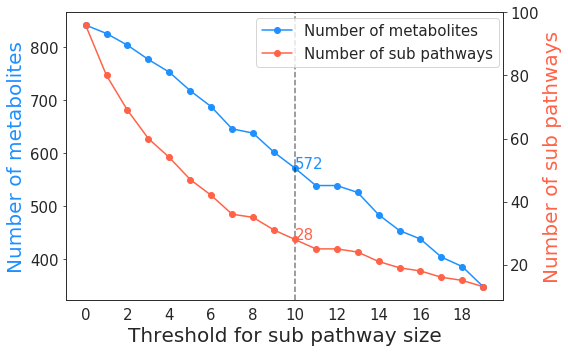

In [594]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ranges = np.arange(0, 20, 1)
ax.plot(ranges, [full_model_labels.SUB_PATHWAY.value_counts()[full_model_labels.SUB_PATHWAY.value_counts()>i].iloc[1:].sum() for i in ranges], '-o', 
        color='dodgerblue', label='Number of metabolites')
ax2 = ax.twinx()
ax2.plot(ranges, [full_model_labels.SUB_PATHWAY.value_counts()[full_model_labels.SUB_PATHWAY.value_counts()>i].iloc[1:].shape[0] for i in ranges], '-o', 
         color='tomato', label='Number of sub pathways')
fig.legend(fontsize=15, bbox_to_anchor=(0.88, 0.95))
ax.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
ax.set_xticks(np.arange(0, 20, 2))
ax.set_ylabel('Number of metabolites', fontsize=20, color='dodgerblue')
ax2.set_ylabel('Number of sub pathways', fontsize=20, color='tomato')
ax.set_xlabel('Threshold for sub pathway size', fontsize=20)

ax.axvline(x=10, color='black', alpha=0.5, linestyle='--')
ax.text(10, 572, '572', fontsize=15, color='dodgerblue')
ax2.text(10, 28, '28', fontsize=15, color='tomato')

fig.tight_layout()

# plt.text(-0.18, 0.95, 'A', ha='center', va='center', transform=axes[0].transAxes, fontsize=30)
# plt.text(-0.18, 0.95, 'B', ha='center', va='center', transform=axes[1].transAxes, fontsize=30)
# plt.text(-0.18, 0.95, 'C', ha='center', va='center', transform=axes[2].transAxes, fontsize=30)

plt.savefig('Supplementary_sub_pathway_size_threshold_small.png', dpi=200, bbox_inches='tight')
plt.savefig('Supplementary_sub_pathway_size_threshold.png', dpi=1200, bbox_inches='tight')

# MultiClass prediction model

## SUPER_PATHWAY

In [83]:
true_y = pd.read_csv('super_pathway_y.csv', index_col=0).astype(str)
y_labels = pd.read_csv('super_pathway_labels.csv', index_col=0, header=None)
y_labels_dic = {str(i):y_labels.loc[i].values[0] for i in y_labels.index}
y_labels

,1
0,
0,Lipid
1,Carbohydrate
2,Xenobiotics
3,Amino Acid
4,Nucleotide
5,Cofactors and Vitamins
6,Peptide


In [84]:
true_y.replace(y_labels_dic)['SUPER_PATHWAY'].value_counts()

Lipid                     380
Amino Acid                195
Xenobiotics               134
Peptide                    40
Nucleotide                 35
Carbohydrate               22
Cofactors and Vitamins     22
Name: SUPER_PATHWAY, dtype: int64

In [250]:
loo_predictions, unknowns_predictions = read_predictions('LOO/')

In [86]:
known_predictions_super_pathway = copy.deepcopy(loo_predictions)

In [87]:
unknow_predictions_super_pathway = copy.deepcopy(unknow_predictions)

In [682]:
unknow_predictions_super_pathway['all_features+levels'].loc[unknow_predictions_super_pathway['all_features+levels'].index.str.startswith('X')]\
.to_csv('Supplementray_unknowns_super_pathways_all_features+levels.csv')

In [644]:
for loo in loo_predictions:
    y_temp = true_y.replace(y_labels_dic).copy()
    print (loo)
    first_hit = _highest_proba_hit(loo_predictions[loo], y_temp)
    y_temp['first'] = first_hit
    print ('first hit:', first_hit.sum())
    b = loo_predictions[loo].copy()
    b[(b.T == b.T.max()).T] = 0
    second_hit = _highest_proba_hit(b, y_temp)
    y_temp['second'] = second_hit
    print ('second hit:', second_hit.sum())
#     print (y_temp.loc[~(y_temp['first'] | y_temp['second']), y_temp.columns[0]].value_counts())
#     print (y_temp.loc[(y_temp['first'] | y_temp['second']), y_temp.columns[0]].value_counts())
#     if loo in unknow_predictions:
#         print ('unknowns')
#         print (unknow_predictions[loo].idxmax(1).value_counts())

shap
first hit: 614
second hit: 103
levels
first hit: 655
second hit: 75
all_features+levels
first hit: 660
second hit: 67
all_features
first hit: 649
second hit: 68
all_features+shap
first hit: 639
second hit: 80
shap+levels
first hit: 649
second hit: 80
all_features+shap+levels
first hit: 652
second hit: 75


/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 720x720 with 0 Axes>

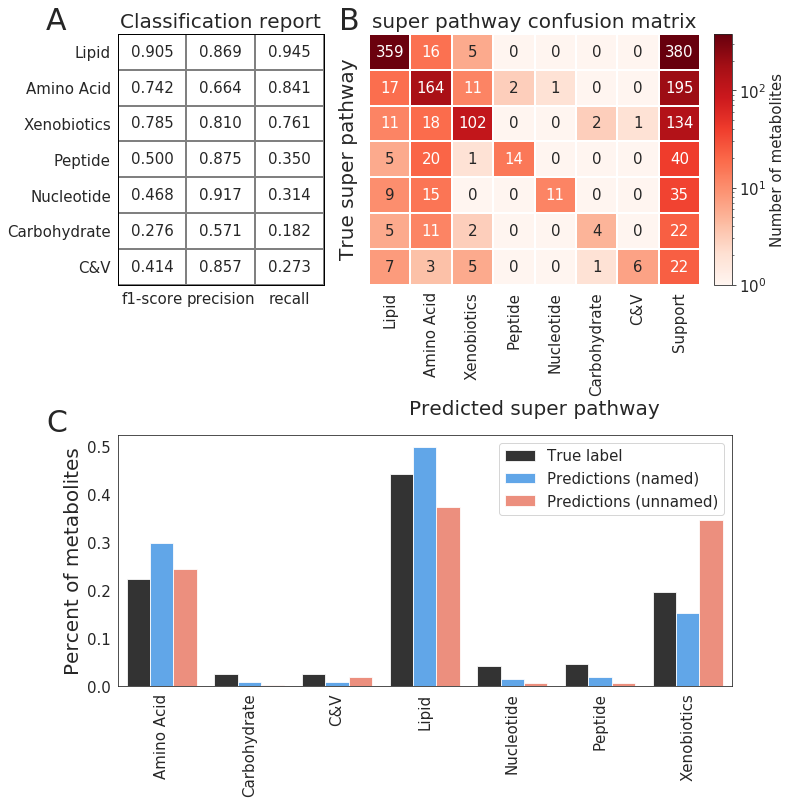

In [97]:
names_dic = {'Cofactors and Vitamins': 'C&V', 'SUPER_PATHWAY': 'super pathway', 'SUB_PATHWAY': 'sub pathway'}
loo='all_features+levels'

con_mat = _multi_class_confusion_matrix(true_y, loo_predictions[loo], y_labels, y_labels_dic).rename(index=names_dic, columns=names_dic)
# cluster the confusion matrix according to the columns
# cg = sns.clustermap(con_mat.apply(lambda x: x/x.sum(), axis=1), xticklabels=False, yticklabels=False, row_cluster=False) # , method='correlation'
cg = sns.clustermap(con_mat, xticklabels=False, yticklabels=False, row_cluster=False) # , method='correlation'
plt.clf()
con_mat = con_mat.iloc[cg.dendrogram_col.reordered_ind, cg.dendrogram_col.reordered_ind]

class_report = pd.DataFrame(classification_report(true_y.replace(y_labels_dic), loo_predictions[loo].loc[true_y.index].idxmax(1), output_dict=True)).T.rename(index=names_dic, columns=names_dic).loc[con_mat.index].drop('support', axis=1)

# con_mat.loc['Total'] = con_mat.sum()
con_mat.loc[:, 'Support'] = con_mat.sum(1)

# fig, axes = plt.subplots(1, 2, figsize=(15, 7))
sns.set_style('white')
fig = plt.figure(figsize=(11, 12))

gs = gridspec.GridSpec(2, 20, wspace=0.8, hspace=0.6)

classification_report_table = fig.add_subplot(gs[:1, :7])
confunsion_matrix_heatmap = fig.add_subplot(gs[:1, 8:19])
confunsion_matrix_colorbar = fig.add_subplot(gs[:1, 19:])
barplot = fig.add_subplot(gs[1:, :])

log_norm = True # None, True
if log_norm:
    log_norm = LogNorm(vmin=1, vmax=con_mat.max().max()+1)
label_fontsize = 20
tick_fontsize = 15

ax = classification_report_table
sns.heatmap(class_report, cmap='binary', vmin=1, vmax=5000, ax=ax, annot=class_report, fmt='0.3f', cbar=False, linecolor='grey', linewidths=1, annot_kws={'size':tick_fontsize})
ax.set_title('Classification report', fontsize=label_fontsize)
# ax.xaxis.set_ticks_position('top')
ax.tick_params(labelsize=tick_fontsize)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color('black')


ax = confunsion_matrix_heatmap
sns.heatmap(con_mat+1, cmap='Reds', annot=con_mat, fmt='d', norm=log_norm, ax=ax, cbar=False, annot_kws={'size':tick_fontsize}, linewidths=1, linecolor='white')
ax.set_yticklabels([])
ax.set_xlabel('Predicted %s'%(true_y.rename(columns=names_dic).columns[0]), fontsize=label_fontsize)
ax.set_ylabel('True %s'%(true_y.rename(columns=names_dic).columns[0]), fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.set_title('%s confusion matrix'%(true_y.rename(columns=names_dic).columns[0]), fontsize=label_fontsize)

cb1 = mpl.colorbar.ColorbarBase(confunsion_matrix_colorbar, cmap='Reds',
                                norm=log_norm, ticks=[1, 10, 100])
cb1.set_label('Number of metabolites')
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(tick_fontsize)


df_super_pathway = pathway_predictions_dist(metabs1[metabs1.SUPER_PATHWAY.isin(known_predictions_super_pathway[loo].columns)].SUPER_PATHWAY.value_counts(), 
                                                                          known_predictions_super_pathway[loo],
                                                                          unknow_predictions_super_pathway[loo].loc[unknow_predictions_super_pathway[loo].index.str.startswith('X')])

ax = barplot
sns.barplot(data=df_super_pathway.rename(index=names_dic).reset_index().melt(id_vars=['index'], value_vars=df_super_pathway.columns).replace('SUPER_PATHWAY', 'True label'), x='index', y='value', hue='variable', 
            ax=ax, palette=['black', 'dodgerblue', 'tomato'], alpha=0.8)
ax.tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Percent of metabolites', fontsize=20)

ax.legend(title='', fontsize=15)


fig.tight_layout()
plt.text(-0.3, 1.05, 'A', ha='center', va='center', transform=classification_report_table.transAxes, fontsize=30)
plt.text(-0.06, 1.05, 'B', ha='center', va='center', transform=confunsion_matrix_heatmap.transAxes, fontsize=30)
plt.text(-0.1, 1.05, 'C', ha='center', va='center', transform=barplot.transAxes, fontsize=30)

plt.savefig('super_pathway_results_small.png', dpi=200, bbox_inches='tight')
plt.savefig('super_pathway_results.png', dpi=1200, bbox_inches='tight')

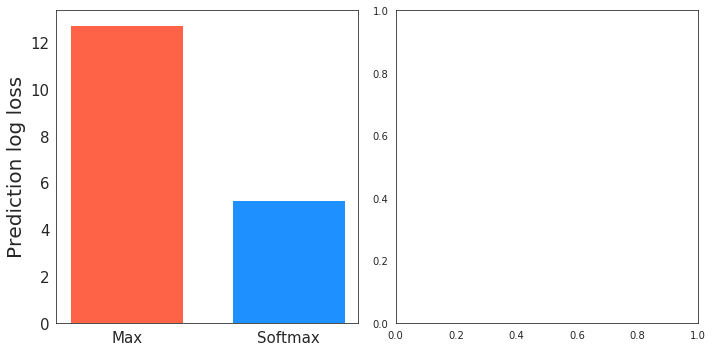

In [677]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
prob = log_loss(pd.get_dummies(true_y.replace(y_labels_dic)), loo_predictions[loo].loc[true_y.index])
dum = log_loss(pd.get_dummies(true_y.replace(y_labels_dic)), pd.get_dummies(loo_predictions[loo].loc[true_y.index].idxmax(1)))

ax.bar([0, 1], [dum, prob], width=0.7, color=['tomato', 'dodgerblue'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['Max', 'Softmax'], fontsize=tick_fontsize)
ax.set_ylabel('Prediction log loss', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)

# ax = axes[1]
# y_temp = true_y.replace(y_labels_dic).copy()
# first_hit = _highest_proba_hit(loo_predictions[loo], y_temp)
# y_temp['first'] = first_hit
# first_sum = first_hit.sum()
# b = loo_predictions[loo].copy()
# b[(b.T == b.T.max()).T] = 0
# second_hit = _highest_proba_hit(b, y_temp)
# y_temp['second'] = second_hit
# second_sum = second_hit.sum()
# ax.bar([0, 1], [first_sum, second_sum], width=0.7, color=['dodgerblue', 'dodgerblue'])
# ax.set_xticks([0, 1])
# ax.set_xticklabels(['1', '2'], fontsize=tick_fontsize)
# ax.set_xlabel('Highest k probabilities', fontsize=label_fontsize)
# ax.set_ylabel('Number of accuratly labeled metabolites', fontsize=label_fontsize)
# ax.tick_params(labelsize=tick_fontsize)

fig.tight_layout()

## SUB_PATHWAY

In [52]:
true_y = pd.read_csv('sub_pathway_y.csv', index_col=0).astype(str)
y_labels = pd.read_csv('sub_pathway_labels.csv', index_col=0)
metabolism_syn = {label:label.replace('Metabolism', 'M.') for label in y_labels.values.ravel()}
y_labels_dic = {str(i):y_labels.loc[i].values[0] for i in y_labels.index}

print (true_y.replace(y_labels_dic)['SUB_PATHWAY'].value_counts())

loo_predictions, unknowns_predictions = read_predictions('LOO/SUB_PATHWAY/')

known_predictions_sub_pathway = copy.deepcopy(loo_predictions)
unknow_predictions_sub_pathway = copy.deepcopy(unknowns_predictions)

# unknow_predictions_sub_pathway['all_features+levels'].loc[unknow_predictions_sub_pathway['all_features+levels'].index.str.startswith('X')]\
# .to_csv('Supplementray_unknowns_sub_pathways_all_features+levels.csv')

# unknow_predictions_sub_pathway['all_features'].loc[unknow_predictions_sub_pathway['all_features'].index.str.startswith('X')]\
# .to_csv('Supplementray_unknowns_sub_pathways_all_features.csv')

unknow_predictions_sub_pathway['all_features+shap+levels'].loc[unknow_predictions_sub_pathway['all_features+shap+levels'].index.str.startswith('X')]\
.to_csv('Supplementary_unknowns_sub_pathways_all_features+shap+levels.csv')

# print (known_predictions_sub_pathway[loo].shape)

for loo in loo_predictions:
    y_temp = true_y.replace(y_labels_dic).copy()
    print (loo)
    first_hit = _highest_proba_hit(loo_predictions[loo], y_temp)
    y_temp['first'] = first_hit
    print ('first hit:', first_hit.sum())
    b = loo_predictions[loo].copy()
    b[(b.T == b.T.max()).T] = 0
    second_hit = _highest_proba_hit(b, y_temp)
    y_temp['second'] = second_hit
    print ('second hit:', second_hit.sum())
#     print (y_temp.loc[~(y_temp['first'] | y_temp['second']), y_temp.columns[0]].value_counts())
#     print (y_temp.loc[(y_temp['first'] | y_temp['second']), y_temp.columns[0]].value_counts())
#     if loo in unknow_predictions:
#         print ('unknowns')
#         print (unknow_predictions[loo].idxmax(1).value_counts())

Food Component/Plant                                44
Sphingolipid Metabolism                             40
Fatty Acid Metabolism(Acyl Carnitine)               30
Leucine, Isoleucine and Valine Metabolism           30
Lysophospholipid                                    28
Drug                                                25
Fatty Acid, Dicarboxylate                           24
Chemical                                            22
Tyrosine Metabolism                                 22
Methionine, Cysteine, SAM and Taurine Metabolism    22
Urea cycle; Arginine and Proline Metabolism         21
Androgenic Steroids                                 20
Tryptophan Metabolism                               20
Benzoate Metabolism                                 19
Phosphatidylcholine (PC)                            19
Secondary Bile Acid Metabolism                      18
Gamma-glutamyl Amino Acid                           17
Polyunsaturated Fatty Acid (n3 and n6)              17
Xanthine M

### figure v1

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 720x720 with 0 Axes>

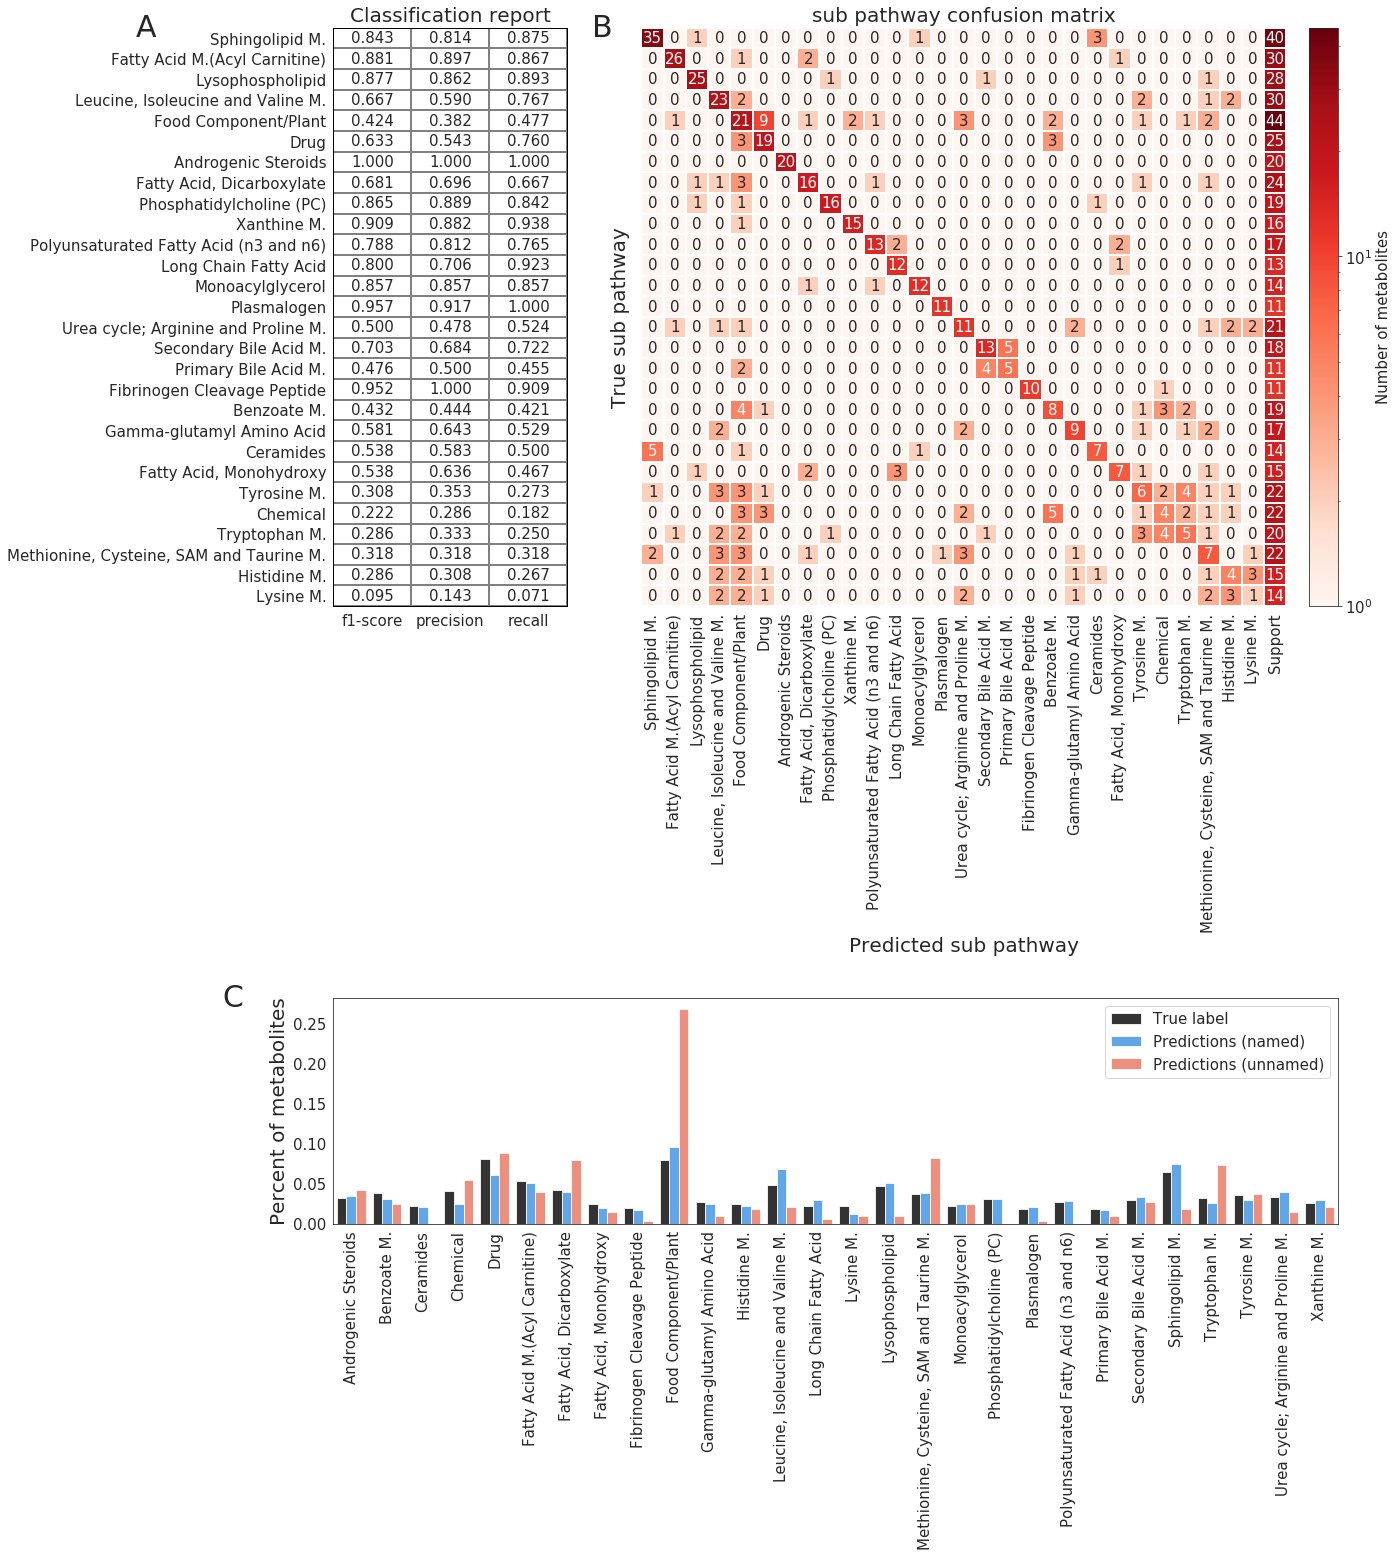

In [113]:
names_dic = {'Cofactors and Vitamins': 'C&V', 'SUPER_PATHWAY': 'super pathway', 'SUB_PATHWAY': 'sub pathway'}
loo='all_features+levels'

con_mat = _multi_class_confusion_matrix(true_y, loo_predictions[loo], y_labels, y_labels_dic).rename(index=names_dic, columns=names_dic)

cg = sns.clustermap(con_mat, xticklabels=False, yticklabels=False, row_cluster=False) # , method='correlation'
plt.clf()
con_mat = con_mat.iloc[cg.dendrogram_col.reordered_ind, cg.dendrogram_col.reordered_ind]

class_report = pd.DataFrame(classification_report(true_y.replace(y_labels_dic), loo_predictions[loo].loc[true_y.index].idxmax(1), output_dict=True)).T.rename(index=names_dic, columns=names_dic).loc[con_mat.index].drop('support', axis=1)

con_mat.rename(metabolism_syn, columns=metabolism_syn, inplace=True)
class_report.rename(metabolism_syn, inplace=True)
# con_mat.loc['Total'] = con_mat.sum()
con_mat.loc[:, 'Support'] = con_mat.sum(1)

# fig, axes = plt.subplots(1, 2, figsize=(15, 7))
sns.set_style('white')
fig = plt.figure(figsize=(18, 22))

gs = gridspec.GridSpec(14, 20, wspace=0.8, hspace=.8)

classification_report_table = fig.add_subplot(gs[:7, :5])
confunsion_matrix_heatmap = fig.add_subplot(gs[:7, 6:19])
confunsion_matrix_colorbar = fig.add_subplot(gs[:7, 19:])
barplot = fig.add_subplot(gs[11:, :])

log_norm = True # None, True
if log_norm:
    log_norm = LogNorm(vmin=1, vmax=con_mat.max().max()+1)
label_fontsize = 20
tick_fontsize = 15

ax = classification_report_table
sns.heatmap(class_report, cmap='binary', vmin=1, vmax=5000, ax=ax, annot=class_report, fmt='0.3f', cbar=False, linecolor='grey', linewidths=1, annot_kws={'size':tick_fontsize})
ax.set_title('Classification report', fontsize=label_fontsize)
# ax.xaxis.set_ticks_position('top')
ax.tick_params(labelsize=tick_fontsize)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color('black')


ax = confunsion_matrix_heatmap
sns.heatmap(con_mat+1, cmap='Reds', annot=con_mat, fmt='d', norm=log_norm, ax=ax, cbar=False, annot_kws={'size':tick_fontsize}, linewidths=1, linecolor='white')
ax.set_yticklabels([])
ax.set_xlabel('Predicted %s'%(true_y.rename(columns=names_dic).columns[0]), fontsize=label_fontsize)
ax.set_ylabel('True %s'%(true_y.rename(columns=names_dic).columns[0]), fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.set_title('%s confusion matrix'%(true_y.rename(columns=names_dic).columns[0]), fontsize=label_fontsize)

cb1 = mpl.colorbar.ColorbarBase(confunsion_matrix_colorbar, cmap='Reds',
                                norm=log_norm, ticks=[1, 10, 100])
cb1.set_label('Number of metabolites')
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(tick_fontsize)


df_sub_pathway = pathway_predictions_dist(metabs1[metabs1.SUB_PATHWAY.isin(known_predictions_sub_pathway[loo].columns)].SUB_PATHWAY.value_counts(), 
                                                                          known_predictions_sub_pathway[loo],
                                                                          unknow_predictions_sub_pathway[loo].loc[unknow_predictions_sub_pathway[loo].index.str.startswith('X')])

ax = barplot
sns.barplot(data=df_sub_pathway.rename(index=metabolism_syn).reset_index().melt(id_vars=['index'], value_vars=df_sub_pathway.columns).replace('SUB_PATHWAY', 'True label'), x='index', y='value', hue='variable', 
            ax=ax, palette=['black', 'dodgerblue', 'tomato'], alpha=0.8)
ax.tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Percent of metabolites', fontsize=20)

ax.legend(title='', fontsize=15)

fig.tight_layout()
plt.text(-0.8, 1.0, 'A', ha='center', va='center', transform=classification_report_table.transAxes, fontsize=30)
plt.text(-0.06, 1.0, 'B', ha='center', va='center', transform=confunsion_matrix_heatmap.transAxes, fontsize=30)
plt.text(-0.1, 1.0, 'C', ha='center', va='center', transform=barplot.transAxes, fontsize=30)

plt.savefig('sub_pathway_results_small.png', dpi=200, bbox_inches='tight')
plt.savefig('sub_pathway_results.png', dpi=1200, bbox_inches='tight')

In [145]:
metabs1.drop_duplicates(subset=['SUB_PATHWAY']).sort_values('SUB_PATHWAY').tail(50)

,Group HMDB_ID,Sample HMDB_ID,BIOCHEMICAL,CAS,CHEMICAL_ID,CHEMSPIDER,KEGG,MASS,PATHWAY_SORTORDER,PLATFORM,PUBCHEM,RI,SUB_PATHWAY,SUPER_PATHWAY,COMMENT
COMP_ID,,,,,,,,,,,,,,,
33971,HMDB60038,NaN,10-heptadecenoate (17:1n7),29743-97-3,100001278,4471860.0,NaN,267.23295,1130.0,LC/MS Neg,5312435.0,5555.0,Long Chain Fatty Acid,Lipid,10-heptadecenoate (17:1n7)
6146,HMDB00510,NaN,2-aminoadipate,542-32-5;1118-90-7,381,456.0,C00956,160.06153,95.0,LC/MS Polar,469.0,3500.0,Lysine Metabolism,Amino Acid,2-aminoadipate
46325,NaN,NaN,1-arachidonoyl-GPA (20:4),799268-65-8,100004442,NaN,NaN,457.23606,1928.0,LC/MS Neg,NaN,5499.0,Lysophospholipid,Lipid,1-arachidonoyl-GPA (20:4)
44621,NaN,NaN,1-(1-enyl-oleoyl)-GPE (P-18:1)*,NaN,100005372,NaN,NaN,464.31360,2150.0,LC/MS Pos Late,NaN,1566.0,Lysoplasmalogen,Lipid,1-(1-enyl-oleoyl)-GPE (P-18:1)*
32497,HMDB33724,NaN,10-undecenoate (11:1n1),1333-28-4,100001197,10771160.0,C13910,183.13905,1117.0,LC/MS Neg,14891.0,5085.8,Medium Chain Fatty Acid,Lipid,10-undecenoate (11:1n1)
47089,HMDB02757,NaN,3-sulfo-L-alanine,498-40-8,382,65718.0,C00506,167.99722,344.0,LC/MS Polar,72886.0,2890.0,"Methionine, Cysteine, SAM and Taurine Metabolism",Amino Acid,3-sulfo-L-alanine
531,HMDB00355,NaN,3-hydroxy-3-methylglutarate,503-49-1,112,4573695.0,C03761,161.04555,2403.0,LC/MS Polar,1662.0,2850.0,Mevalonate Metabolism,Lipid,3-hydroxy-3-methylglutarate
34397,HMDB11549,NaN,1-arachidonylglycerol (20:4),35474-99-8,100001433,4445452.0,C13857,303.23293,2175.0,LC/MS Neg,5282281.0,6250.0,Monoacylglycerol,Lipid,1-arachidonylglycerol (20:4)
27665,HMDB00699,NaN,1-methylnicotinamide,1005-24-9,55,8305504.0,C02918,137.07094,3389.0,LC/MS Pos Early,10129985.0,1940.0,Nicotinate and Nicotinamide Metabolism,Cofactors and Vitamins,1-methylnicotinamide


### figure v2

In [26]:
sub_pathway_2_super_pathway_dict = metabs1.replace({'Lipid':'Lipids', 'Nucleotide':'Nucleotides', 'Amino Acid':'Amino acids', 'Peptide':'Peptides', 
                                       'Xenobiotics':'Xeno.', 'Unknown':'Unknowns', 'Carbohydrate':'Carbohydrates'})[['SUB_PATHWAY', 'SUPER_PATHWAY']].set_index('SUB_PATHWAY').to_dict()['SUPER_PATHWAY']

In [55]:
con_mat.rename(index=sub_pathway_2_super_pathway_dict)

,Xanthine Metabolism,Drug,Food Component/Plant,Chemical,Benzoate Metabolism,Secondary Bile Acid Metabolism,Primary Bile Acid Metabolism,Lysophospholipid,Phosphatidylcholine (PC),Fatty Acid Metabolism(Acyl Carnitine),...,Plasmalogen,Tryptophan Metabolism,Tyrosine Metabolism,"Leucine, Isoleucine and Valine Metabolism",Histidine Metabolism,Lysine Metabolism,"Methionine, Cysteine, SAM and Taurine Metabolism",Urea cycle; Arginine and Proline Metabolism,Gamma-glutamyl Amino Acid,Fibrinogen Cleavage Peptide
Xeno.,15,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Xeno.,0,19,3,0,2,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Xeno.,2,9,23,0,2,0,0,0,0,1,...,0,1,1,0,0,0,2,2,0,0
Xeno.,0,4,4,3,3,0,0,0,0,0,...,0,3,1,0,1,0,1,2,0,0
Xeno.,0,1,5,3,9,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Lipids,0,0,0,0,0,14,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lipids,0,0,2,0,0,4,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lipids,0,0,0,0,0,0,1,25,1,0,...,0,0,0,0,0,0,1,0,0,0
Lipids,0,0,1,0,0,0,0,2,16,0,...,0,0,0,0,0,0,0,0,0,0
Lipids,0,0,0,0,0,0,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0


Xeno.
Lipids
Amino acids
Peptides


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

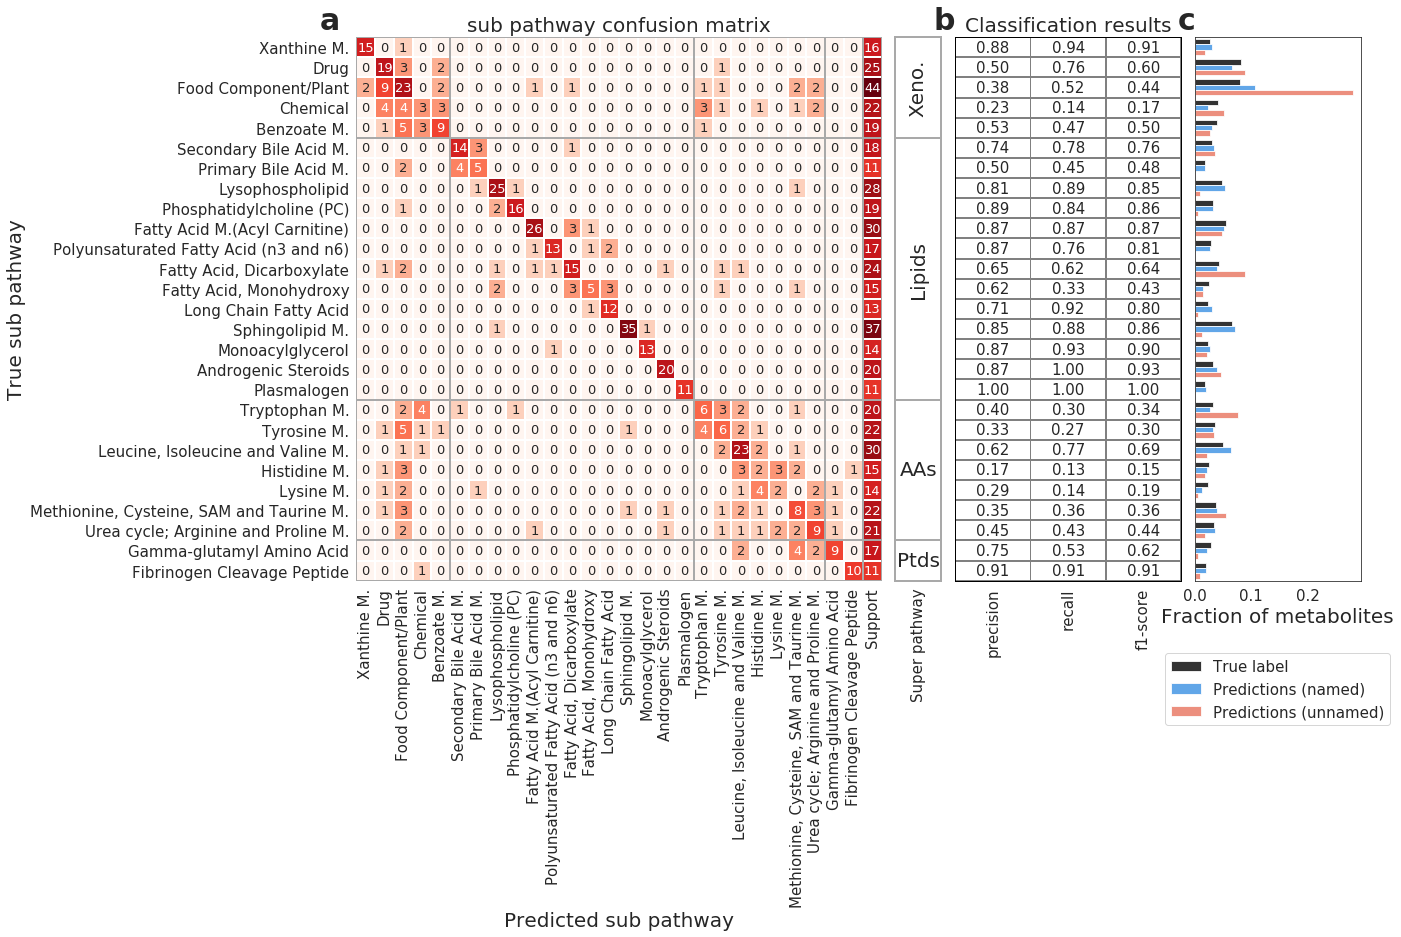

In [58]:
names_dic = {'Cofactors and Vitamins': 'C&V', 'SUPER_PATHWAY': 'super pathway', 'SUB_PATHWAY': 'sub pathway'}
loo='all_features+shap+levels'
# loo='all_features'

con_mat = _multi_class_confusion_matrix(true_y, loo_predictions[loo].loc[true_y.index], y_labels, y_labels_dic)#.rename(index=names_dic, columns=names_dic)

con_mat_super_pathway = con_mat.rename(index=sub_pathway_2_super_pathway_dict).index.copy()
con_mat['SUPER_PATHWAY'] = con_mat_super_pathway


temp_data = con_mat.copy()
# break heatmap into sections
rel_sp = con_mat_super_pathway.unique()
rel_sp_dic, sp_pos_dic = {}, {}
for sp in rel_sp:
    print (sp)
    temp_data_sp = temp_data.loc[con_mat_super_pathway==sp].copy()
    if temp_data_sp.shape[0] == 1:  # don't include pathways with one metabolite
        continue
    cg = sns.clustermap(temp_data_sp.drop('SUPER_PATHWAY', axis=1), xticklabels=False, yticklabels=False, col_cluster=False, metric='correlation')
    plt.clf()  # cluster metabolites within each section
    rel_sp_dic[sp] = temp_data_sp.iloc[cg.dendrogram_row.reordered_ind, :]
    sp_pos_dic[sp] = temp_data_sp.shape[0] / 2.

# concat the new heatmap
con_mat = pd.concat([rel_sp_dic[sp] for sp in rel_sp_dic])
con_mat_super_pathway = con_mat.rename(index=sub_pathway_2_super_pathway_dict).index.copy()
con_mat = con_mat.loc[:, con_mat.index]
con_mat.rename(index=names_dic, columns=names_dic, inplace=True)


class_report = pd.DataFrame(classification_report(true_y.replace(y_labels_dic), loo_predictions[loo].loc[true_y.index].idxmax(1), output_dict=True)).T.rename(index=names_dic, columns=names_dic).loc[con_mat.index].drop('support', axis=1)

con_mat.rename(index=metabolism_syn, columns=metabolism_syn, inplace=True)
class_report.rename(metabolism_syn, inplace=True)
# con_mat.loc['Total'] = con_mat.sum()
con_mat.loc[:, 'Support'] = con_mat.sum(1)

# fig, axes = plt.subplots(1, 2, figsize=(15, 7))
sns.set_style('white')
fig = plt.figure(figsize=(18, 10))

gs = gridspec.GridSpec(1, 17, wspace=0.3, hspace=.8)

confunsion_matrix_heatmap = fig.add_subplot(gs[:, :9])
super_pathway_column = fig.add_subplot(gs[:, 9:10])
classification_report_table = fig.add_subplot(gs[:, 10:14])
barplot = fig.add_subplot(gs[:, 14:])

log_norm = True # None, True
if log_norm:
    log_norm = LogNorm(vmin=1, vmax=con_mat.max().max()+1)
label_fontsize = 20
tick_fontsize = 15

ax = classification_report_table
sns.heatmap(class_report, cmap='binary', vmin=1, vmax=5000, ax=ax, annot=class_report, fmt='0.2f', cbar=False, linecolor='grey', linewidths=1, annot_kws={'size':tick_fontsize})
ax.set_title('Classification results', fontsize=label_fontsize)
ax.set_yticks([])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.xaxis.set_ticks_position('top')
ax.tick_params(labelsize=tick_fontsize)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color('black')


ax = confunsion_matrix_heatmap
g_main = sns.heatmap(con_mat+1, cmap='Reds', annot=con_mat, fmt='d', norm=log_norm, ax=ax, cbar=False, annot_kws={'size':tick_fontsize-2}, linewidths=1, linecolor='white')
ax.set_xlabel('Predicted %s'%(true_y.rename(columns=names_dic).columns[0]), fontsize=label_fontsize)
ax.set_ylabel('True %s'%(true_y.rename(columns=names_dic).columns[0]), fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.set_title('%s confusion matrix'%(true_y.rename(columns=names_dic).columns[0]), fontsize=label_fontsize)

# # write the super pathways in the heatmap
value_to_int = {value: i for i, value in enumerate(con_mat_super_pathway.unique())}
white_colors = mpl.colors.ListedColormap(['white' for w in con_mat.index])  # only white

g = sns.heatmap(pd.DataFrame([0 for i in con_mat.index]), 
                cmap=white_colors, ax=super_pathway_column, cbar=False, yticklabels=False)  # draw the super pathway heatmap
super_pathway_column.set_ylabel('')
super_pathway_column.set_xticklabels(['Super pathway'], fontsize=tick_fontsize, rotation=90)

cum = 0
for sp in con_mat_super_pathway.unique():
    g.add_patch(Rectangle((0, cum), 1, sp_pos_dic[sp]*2, fill=False, edgecolor='darkgrey', lw=2))
    g_main.add_patch(Rectangle((0, cum), con_mat.shape[1], sp_pos_dic[sp]*2, fill=False, edgecolor='darkgrey', lw=2))
    g_main.add_patch(Rectangle((cum, 0), sp_pos_dic[sp]*2, con_mat.shape[1], fill=False, edgecolor='darkgrey', lw=2))
    cum += sp_pos_dic[sp]
    pep_aa_dic = {'Peptides':'Ptds', 'Amino acids':'AAs', 'Cofactors and Vitamins':'C&V'}
    if sp in pep_aa_dic:
        super_pathway_column.text(0.5, cum, pep_aa_dic[sp], ha='center', va='center', fontsize=label_fontsize)    
    else:
        super_pathway_column.text(0.5, cum, sp, rotation=90, fontsize=label_fontsize, ha='center', va='center')
    cum += sp_pos_dic[sp]
 
for _, spine in super_pathway_column.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_color('darkgrey')

# cb1 = mpl.colorbar.ColorbarBase(confunsion_matrix_colorbar, cmap='Reds',
#                                 norm=log_norm, ticks=[1, 10, 100])
# cb1.set_label('Number of metabolites')
# cb1.ax.tick_params(labelsize=tick_fontsize)
# cb1.ax.yaxis.label.set_size(tick_fontsize)


df_sub_pathway = pathway_predictions_dist(metabs1[metabs1.SUB_PATHWAY.isin(known_predictions_sub_pathway[loo].columns)].SUB_PATHWAY.value_counts(), 
                                                                          known_predictions_sub_pathway[loo],
                                                                          unknow_predictions_sub_pathway[loo].loc[unknow_predictions_sub_pathway[loo].index.str.startswith('X')])
df_sub_pathway.rename(columns={'SUB_PATHWAY': 'True label'}).to_csv('Supplementary_table_unknown_df_sub_pathway.csv')

ax = barplot
df_sub_pathway = df_sub_pathway.rename(index=metabolism_syn).reset_index().melt(id_vars=['index'], value_vars=df_sub_pathway.columns).replace('SUB_PATHWAY', 'True label')
sns.barplot(data=df_sub_pathway.set_index('index').loc[con_mat.index].reset_index(), 
            y='index', x='value', hue='variable', orient='h',
            ax=ax, palette=['black', 'dodgerblue', 'tomato'], alpha=0.8)
ax.tick_params(labelsize=15)
# ax.set_yticks(con_mat.index)
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('Fraction of metabolites', fontsize=20)

ax.legend(title='', fontsize=15, loc='center', bbox_to_anchor=(0.5, -0.2))

fig.tight_layout()
plt.text(-0.05, 1.03, 'a', ha='center', va='center', transform=confunsion_matrix_heatmap.transAxes, fontsize=30, weight='bold')
plt.text(-0.05, 1.03, 'b', ha='center', va='center', transform=classification_report_table.transAxes, fontsize=30, weight='bold')
plt.text(-0.05, 1.03, 'c', ha='center', va='center', transform=barplot.transAxes, fontsize=30, weight='bold')

plt.savefig('sub_pathway_results_v2_small.png', dpi=200, bbox_inches='tight')
plt.savefig('sub_pathway_results_v2.png', dpi=1200, bbox_inches='tight')

In [388]:
pathway_predictions_dist(metabs1[metabs1.SUB_PATHWAY.isin(known_predictions_sub_pathway[loo].columns)].SUB_PATHWAY.value_counts(), 
                                                                          known_predictions_sub_pathway[loo],
                                                                          unknow_predictions_sub_pathway[loo].loc[unknow_predictions_sub_pathway[loo].index.str.startswith('X')])

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,SUB_PATHWAY,Predictions (named),Predictions (unnamed)
Androgenic Steroids,0.032310,0.040210,0.045732
Benzoate Metabolism,0.038772,0.029720,0.027439
Ceramides,0.022617,0.017483,NaN
Chemical,0.040388,0.022727,0.051829
Drug,0.080775,0.066434,0.088415
Fatty Acid Metabolism(Acyl Carnitine),0.053312,0.052448,0.048780
"Fatty Acid, Dicarboxylate",0.042003,0.040210,0.088415
"Fatty Acid, Monohydroxy",0.024233,0.013986,0.015244
Fibrinogen Cleavage Peptide,0.019386,0.019231,0.009146
Food Component/Plant,0.079160,0.106643,0.280488


In [443]:
def _compute_binom(df_sub_pathway, sub_pathway, n):
    print (sub_pathway)
    sp = (df_sub_pathway['index'] == sub_pathway)
    print (df_sub_pathway.loc[sp])
    print(binom_test(x=int(n*df_sub_pathway.loc[sp & (df_sub_pathway['variable'] == 'Predictions (unnamed)'), 'value']), 
                           p=df_sub_pathway.loc[sp & (df_sub_pathway['variable'] == 'Predictions (named)'), 'value'].values[0],
                           n=n, alternative='two-sided'))
    print(binom_test(x=int(n*(df_sub_pathway.loc[sp & (df_sub_pathway['variable'] == 'Predictions (named)'), 'value'])), 
                           p=df_sub_pathway.loc[sp & (df_sub_pathway['variable'] == 'True label'), 'value'].values[0],
                           n=n, alternative='two-sided'))
    
_compute_binom(df_sub_pathway, 'Food Component/Plant', unknow_predictions_sub_pathway[loo].loc[unknow_predictions_sub_pathway[loo].index.str.startswith('X')].shape[0])
_compute_binom(df_sub_pathway, 'Tryptophan M.', unknow_predictions_sub_pathway[loo].loc[unknow_predictions_sub_pathway[loo].index.str.startswith('X')].shape[0])
_compute_binom(df_sub_pathway, 'Fatty Acid, Dicarboxylate', unknow_predictions_sub_pathway[loo].loc[unknow_predictions_sub_pathway[loo].index.str.startswith('X')].shape[0])
_compute_binom(df_sub_pathway, 'Sphingolipid M.', unknow_predictions_sub_pathway[loo].loc[unknow_predictions_sub_pathway[loo].index.str.startswith('X')].shape[0])
_compute_binom(df_sub_pathway, 'Lysophospholipid', unknow_predictions_sub_pathway[loo].loc[unknow_predictions_sub_pathway[loo].index.str.startswith('X')].shape[0])

Food Component/Plant
                   index               variable     value
9   Food Component/Plant             True label  0.079160
37  Food Component/Plant    Predictions (named)  0.106643
65  Food Component/Plant  Predictions (unnamed)  0.280488
2.445047025497384e-18
0.10170612382297997
Tryptophan M.
            index               variable     value
24  Tryptophan M.             True label  0.032310
52  Tryptophan M.    Predictions (named)  0.026224
80  Tryptophan M.  Predictions (unnamed)  0.076220
2.6879012304456144e-06
0.5312173413387309
Fatty Acid, Dicarboxylate
                        index               variable     value
6   Fatty Acid, Dicarboxylate             True label  0.042003
34  Fatty Acid, Dicarboxylate    Predictions (named)  0.040210
62  Fatty Acid, Dicarboxylate  Predictions (unnamed)  0.088415
9.756705876674986e-05
1.0
Sphingolipid M.
              index               variable     value
23  Sphingolipid M.             True label  0.064620
51  Sphingolipid M.

### Supp figure

[0.6311188811188811, 0.7657342657342657, 0.8216783216783217, 0.8583916083916083, 0.8933566433566433, 0.9125874125874126]


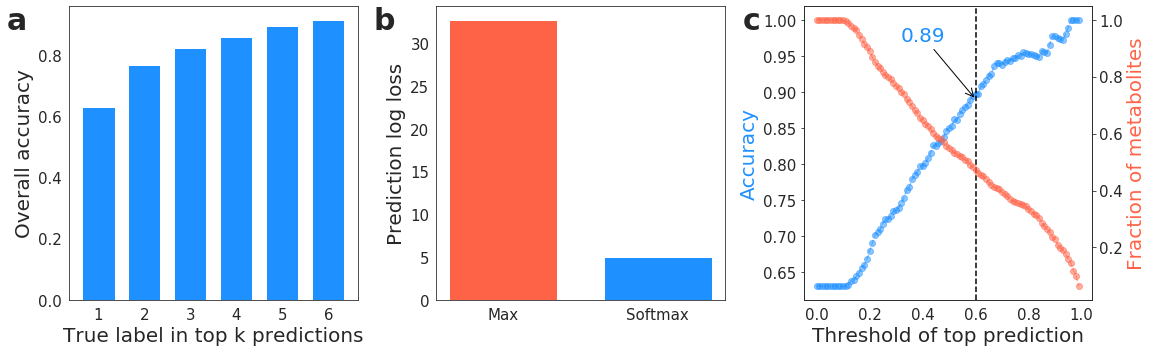

In [60]:
loo = 'all_features+shap+levels'
acc_vs_max_df = accuracy_vs_max(true_y, y_labels_dic, loo_predictions[loo])
acc_vs_max_df['Accuracy'] = acc_vs_max_df['Hit'] / acc_vs_max_df['n']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
tick_fontsize = 15
label_fontsize = 20

ax = axes[0]
y_temp = true_y.replace(y_labels_dic).copy()
first_hit = _highest_proba_hit(loo_predictions[loo], y_temp)
k_acc = [first_hit.sum()/y_temp.shape[0]]
b = loo_predictions[loo].copy()
for i in range(5):
    b[(b.T == b.T.max()).T] = 0
    hit = _highest_proba_hit(b, y_temp)
    k_acc.append(hit.sum()/y_temp.shape[0] + k_acc[-1])
print (k_acc)
ax.bar(range(len(k_acc)), k_acc, width=0.7, color='dodgerblue')
ax.set_xticks(range(len(k_acc)))
ax.set_xticklabels(range(1, len(k_acc)+1), fontsize=tick_fontsize)
ax.set_xlabel('True label in top k predictions', fontsize=label_fontsize)
ax.set_ylabel('Overall accuracy', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)

ax = axes[1]
prob = log_loss(pd.get_dummies(true_y.replace(y_labels_dic)), loo_predictions[loo].loc[true_y.index])
dum = log_loss(pd.get_dummies(true_y.replace(y_labels_dic)), loo_predictions[loo].loc[true_y.index].apply(lambda x: x == x.max(), axis=1).astype(int))

ax.bar([0, 1], [dum, prob], width=0.7, color=['tomato', 'dodgerblue'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['Max', 'Softmax'], fontsize=tick_fontsize)
ax.set_ylabel('Prediction log loss', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)

ax = axes[2]
ax.plot(acc_vs_max_df.index, acc_vs_max_df['Accuracy'], 'o--', color='dodgerblue', alpha=0.5)
ax.axvline(x=0.6, linestyle='--', color='black')

ax.annotate('0.89', (0.6, 0.89), (0.4, 0.97),arrowprops={'arrowstyle':'->',  'color':'black'}, ha='center', fontsize=label_fontsize, color='dodgerblue')
ax2 = ax.twinx()
ax2.plot(acc_vs_max_df.index, acc_vs_max_df['n'] / true_y.shape[0], 'o--', color='tomato', alpha=0.5)
ax.tick_params(labelsize=tick_fontsize)
ax2.tick_params(labelsize=tick_fontsize)
ax.set_ylabel('Accuracy', fontsize=label_fontsize, color='dodgerblue')
ax2.set_ylabel('Fraction of metabolites', fontsize=label_fontsize, color='tomato')
ax.set_xlabel('Threshold of top prediction', fontsize=label_fontsize)

fig.tight_layout()

plt.text(-0.18, 0.95, 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight='bold')
plt.text(-0.18, 0.95, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight='bold')
plt.text(-0.18, 0.95, 'c', ha='center', va='center', transform=axes[2].transAxes, fontsize=30, weight='bold')

plt.savefig('Supplementary_sub_pathway_small.png', dpi=200, bbox_inches='tight')
plt.savefig('Supplementary_sub_pathway.png', dpi=1200, bbox_inches='tight')

### Final supp figure (all)

[0.6311188811188811, 0.7657342657342657, 0.8216783216783217, 0.8583916083916083, 0.8933566433566433, 0.9125874125874126]
Xeno.
Lipids
Amino acids
Peptides


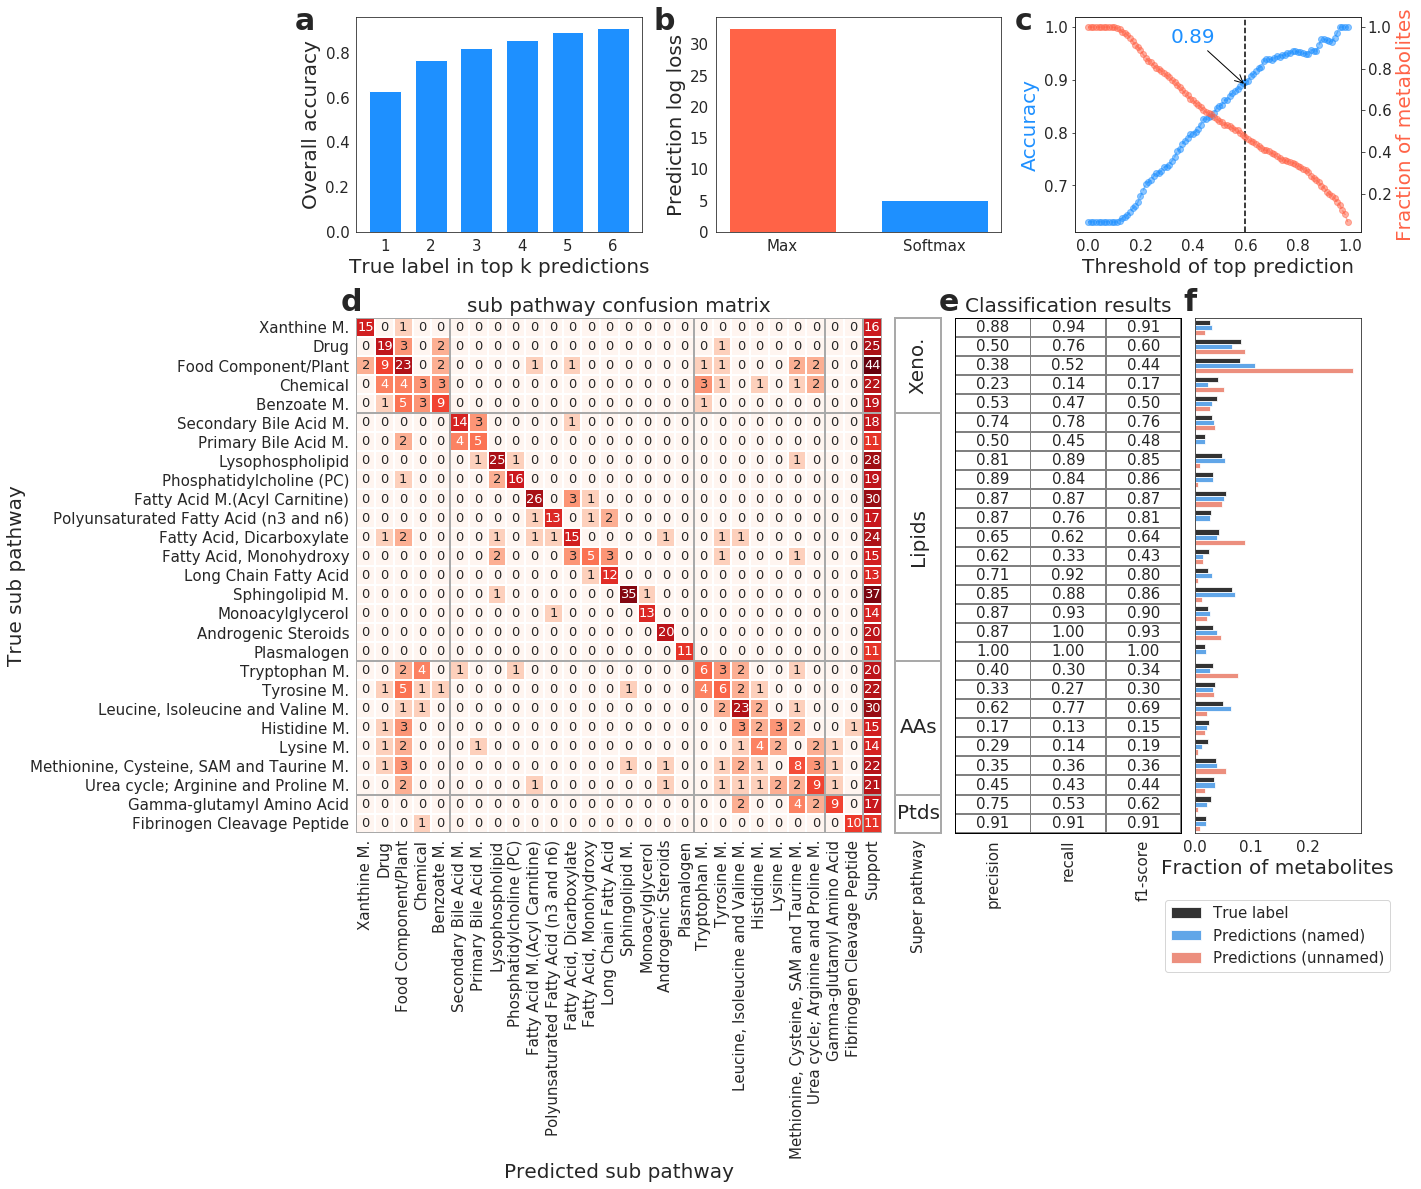

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [78]:
loo = 'all_features+shap+levels'
acc_vs_max_df = accuracy_vs_max(true_y, y_labels_dic, loo_predictions[loo])
acc_vs_max_df['Accuracy'] = acc_vs_max_df['Hit'] / acc_vs_max_df['n']

fig = plt.figure(figsize=(18, 15))

gs = gridspec.GridSpec(3, 17, wspace=0.3, hspace=.4)
confunsion_matrix_heatmap = fig.add_subplot(gs[1:, :9])
super_pathway_column = fig.add_subplot(gs[1:, 9:10])
classification_report_table = fig.add_subplot(gs[1:, 10:14])
barplot = fig.add_subplot(gs[1:, 14:])

top_k = fig.add_subplot(gs[0, :5])
soft_max = fig.add_subplot(gs[0, 6:11])
top_prediction_th = fig.add_subplot(gs[0, 12:17])
# th_panel = fig.add_subplot(gs[0, 12:])


tick_fontsize = 15
label_fontsize = 20

ax = top_k
y_temp = true_y.replace(y_labels_dic).copy()
first_hit = _highest_proba_hit(loo_predictions[loo], y_temp)
k_acc = [first_hit.sum()/y_temp.shape[0]]
b = loo_predictions[loo].copy()
for i in range(5):
    b[(b.T == b.T.max()).T] = 0
    hit = _highest_proba_hit(b, y_temp)
    k_acc.append(hit.sum()/y_temp.shape[0] + k_acc[-1])
print (k_acc)
ax.bar(range(len(k_acc)), k_acc, width=0.7, color='dodgerblue')
ax.set_xticks(range(len(k_acc)))
ax.set_xticklabels(range(1, len(k_acc)+1), fontsize=tick_fontsize)
ax.set_xlabel('True label in top k predictions', fontsize=label_fontsize)
ax.set_ylabel('Overall accuracy', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)

ax = soft_max
prob = log_loss(pd.get_dummies(true_y.replace(y_labels_dic)), loo_predictions[loo].loc[true_y.index])
dum = log_loss(pd.get_dummies(true_y.replace(y_labels_dic)), loo_predictions[loo].loc[true_y.index].apply(lambda x: x == x.max(), axis=1).astype(int))

ax.bar([0, 1], [dum, prob], width=0.7, color=['tomato', 'dodgerblue'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['Max', 'Softmax'], fontsize=tick_fontsize)
ax.set_ylabel('Prediction log loss', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)

ax = top_prediction_th
ax.plot(acc_vs_max_df.index, acc_vs_max_df['Accuracy'], 'o--', color='dodgerblue', alpha=0.5)
ax.axvline(x=0.6, linestyle='--', color='black')

ax.annotate('0.89', (0.6, 0.89), (0.4, 0.97),arrowprops={'arrowstyle':'->',  'color':'black'}, ha='center', fontsize=label_fontsize, color='dodgerblue')
ax2 = ax.twinx()
ax2.plot(acc_vs_max_df.index, acc_vs_max_df['n'] / true_y.shape[0], 'o--', color='tomato', alpha=0.5)
ax.tick_params(labelsize=tick_fontsize)
ax2.tick_params(labelsize=tick_fontsize)
ax.set_ylabel('Accuracy', fontsize=label_fontsize, color='dodgerblue')
ax2.set_ylabel('Fraction of metabolites', fontsize=label_fontsize, color='tomato')
ax.set_xlabel('Threshold of top prediction', fontsize=label_fontsize)

# ax = th_panel
# ranges = np.arange(0, 20, 1)
# ax.plot(ranges, [full_model_labels.SUB_PATHWAY.value_counts()[full_model_labels.SUB_PATHWAY.value_counts()>i].iloc[1:].sum() for i in ranges], '-o', 
#         color='dodgerblue', label='Number of metabolites')
# ax2 = ax.twinx()
# ax2.plot(ranges, [full_model_labels.SUB_PATHWAY.value_counts()[full_model_labels.SUB_PATHWAY.value_counts()>i].iloc[1:].shape[0] for i in ranges], '-o', 
#          color='tomato', label='Number of sub pathways')
# fig.legend(fontsize=15, bbox_to_anchor=(0.88, 0.95))
# ax.tick_params(labelsize=15)
# ax2.tick_params(labelsize=15)
# ax.set_xticks(np.arange(0, 20, 2))
# ax.set_ylabel('Number of metabolites', fontsize=20, color='dodgerblue')
# ax2.set_ylabel('Number of sub pathways', fontsize=20, color='tomato')
# ax.set_xlabel('Threshold for sub pathway size', fontsize=20)

# ax.axvline(x=10, color='black', alpha=0.5, linestyle='--')
# ax.text(10, 572, '572', fontsize=15, color='dodgerblue')
# ax2.text(10, 28, '28', fontsize=15, color='tomato')

plt.text(-0.18, 0.98, 'a', ha='center', va='center', transform=top_k.transAxes, fontsize=30, weight='bold')
plt.text(-0.18, 0.98, 'b', ha='center', va='center', transform=soft_max.transAxes, fontsize=30, weight='bold')
plt.text(-0.18, 0.98, 'c', ha='center', va='center', transform=top_prediction_th.transAxes, fontsize=30, weight='bold')

plt.text(-0.01, 1.03, 'd', ha='center', va='center', transform=confunsion_matrix_heatmap.transAxes, fontsize=30, weight='bold')
plt.text(-0.03, 1.03, 'e', ha='center', va='center', transform=classification_report_table.transAxes, fontsize=30, weight='bold')
plt.text(-0.03, 1.03, 'f', ha='center', va='center', transform=barplot.transAxes, fontsize=30, weight='bold')


names_dic = {'Cofactors and Vitamins': 'C&V', 'SUPER_PATHWAY': 'super pathway', 'SUB_PATHWAY': 'sub pathway'}
loo='all_features+shap+levels'
# loo='all_features'

con_mat = _multi_class_confusion_matrix(true_y, loo_predictions[loo].loc[true_y.index], y_labels, y_labels_dic)#.rename(index=names_dic, columns=names_dic)

con_mat_super_pathway = con_mat.rename(index=sub_pathway_2_super_pathway_dict).index.copy()
con_mat['SUPER_PATHWAY'] = con_mat_super_pathway


temp_data = con_mat.copy()
# break heatmap into sections
rel_sp = con_mat_super_pathway.unique()
rel_sp_dic, sp_pos_dic = {}, {}
for sp in rel_sp:
    print (sp)
    temp_data_sp = temp_data.loc[con_mat_super_pathway==sp].copy()
    if temp_data_sp.shape[0] == 1:  # don't include pathways with one metabolite
        continue
    cg = sns.clustermap(temp_data_sp.drop('SUPER_PATHWAY', axis=1), xticklabels=False, yticklabels=False, col_cluster=False, metric='correlation')
    plt.clf()  # cluster metabolites within each section
    rel_sp_dic[sp] = temp_data_sp.iloc[cg.dendrogram_row.reordered_ind, :]
    sp_pos_dic[sp] = temp_data_sp.shape[0] / 2.

# concat the new heatmap
con_mat = pd.concat([rel_sp_dic[sp] for sp in rel_sp_dic])
con_mat_super_pathway = con_mat.rename(index=sub_pathway_2_super_pathway_dict).index.copy()
con_mat = con_mat.loc[:, con_mat.index]
con_mat.rename(index=names_dic, columns=names_dic, inplace=True)


class_report = pd.DataFrame(classification_report(true_y.replace(y_labels_dic), loo_predictions[loo].loc[true_y.index].idxmax(1), output_dict=True)).T.rename(index=names_dic, columns=names_dic).loc[con_mat.index].drop('support', axis=1)

con_mat.rename(index=metabolism_syn, columns=metabolism_syn, inplace=True)
class_report.rename(metabolism_syn, inplace=True)
# con_mat.loc['Total'] = con_mat.sum()
con_mat.loc[:, 'Support'] = con_mat.sum(1)

# sns.set_style('white')

log_norm = True # None, True
if log_norm:
    log_norm = LogNorm(vmin=1, vmax=con_mat.max().max()+1)
label_fontsize = 20
tick_fontsize = 15

ax = classification_report_table
sns.heatmap(class_report, cmap='binary', vmin=1, vmax=5000, ax=ax, annot=class_report, fmt='0.2f', cbar=False, linecolor='grey', linewidths=1, annot_kws={'size':tick_fontsize})
ax.set_title('Classification results', fontsize=label_fontsize)
ax.set_yticks([])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.xaxis.set_ticks_position('top')
ax.tick_params(labelsize=tick_fontsize)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color('black')


ax = confunsion_matrix_heatmap
g_main = sns.heatmap(con_mat+1, cmap='Reds', annot=con_mat, fmt='d', norm=log_norm, ax=ax, cbar=False, annot_kws={'size':tick_fontsize-2}, linewidths=1, linecolor='white')
ax.set_xlabel('Predicted %s'%(true_y.rename(columns=names_dic).columns[0]), fontsize=label_fontsize)
ax.set_ylabel('True %s'%(true_y.rename(columns=names_dic).columns[0]), fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.set_title('%s confusion matrix'%(true_y.rename(columns=names_dic).columns[0]), fontsize=label_fontsize)

# # write the super pathways in the heatmap
value_to_int = {value: i for i, value in enumerate(con_mat_super_pathway.unique())}
white_colors = mpl.colors.ListedColormap(['white' for w in con_mat.index])  # only white

g = sns.heatmap(pd.DataFrame([0 for i in con_mat.index]), 
                cmap=white_colors, ax=super_pathway_column, cbar=False, yticklabels=False)  # draw the super pathway heatmap
super_pathway_column.set_ylabel('')
super_pathway_column.set_xticklabels(['Super pathway'], fontsize=tick_fontsize, rotation=90)

cum = 0
for sp in con_mat_super_pathway.unique():
    g.add_patch(Rectangle((0, cum), 1, sp_pos_dic[sp]*2, fill=False, edgecolor='darkgrey', lw=2))
    g_main.add_patch(Rectangle((0, cum), con_mat.shape[1], sp_pos_dic[sp]*2, fill=False, edgecolor='darkgrey', lw=2))
    g_main.add_patch(Rectangle((cum, 0), sp_pos_dic[sp]*2, con_mat.shape[1], fill=False, edgecolor='darkgrey', lw=2))
    cum += sp_pos_dic[sp]
    pep_aa_dic = {'Peptides':'Ptds', 'Amino acids':'AAs', 'Cofactors and Vitamins':'C&V'}
    if sp in pep_aa_dic:
        super_pathway_column.text(0.5, cum, pep_aa_dic[sp], ha='center', va='center', fontsize=label_fontsize)    
    else:
        super_pathway_column.text(0.5, cum, sp, rotation=90, fontsize=label_fontsize, ha='center', va='center')
    cum += sp_pos_dic[sp]
 
for _, spine in super_pathway_column.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_color('darkgrey')

# cb1 = mpl.colorbar.ColorbarBase(confunsion_matrix_colorbar, cmap='Reds',
#                                 norm=log_norm, ticks=[1, 10, 100])
# cb1.set_label('Number of metabolites')
# cb1.ax.tick_params(labelsize=tick_fontsize)
# cb1.ax.yaxis.label.set_size(tick_fontsize)


df_sub_pathway = pathway_predictions_dist(metabs1[metabs1.SUB_PATHWAY.isin(known_predictions_sub_pathway[loo].columns)].SUB_PATHWAY.value_counts(), 
                                                                          known_predictions_sub_pathway[loo],
                                                                          unknow_predictions_sub_pathway[loo].loc[unknow_predictions_sub_pathway[loo].index.str.startswith('X')])
# df_sub_pathway.rename(columns={'SUB_PATHWAY': 'True label'}).to_csv('Supplementary_table_unknown_df_sub_pathway.csv')

ax = barplot
df_sub_pathway = df_sub_pathway.rename(index=metabolism_syn).reset_index().melt(id_vars=['index'], value_vars=df_sub_pathway.columns).replace('SUB_PATHWAY', 'True label')
sns.barplot(data=df_sub_pathway.set_index('index').loc[con_mat.index].reset_index(), 
            y='index', x='value', hue='variable', orient='h',
            ax=ax, palette=['black', 'dodgerblue', 'tomato'], alpha=0.8)
ax.tick_params(labelsize=15)
# ax.set_yticks(con_mat.index)
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('Fraction of metabolites', fontsize=20)

ax.legend(title='', fontsize=15, loc='center', bbox_to_anchor=(0.5, -0.2))

# plt.text(-0.18, 0.95, 'a', ha='center', va='center', transform=top_k.transAxes, fontsize=30, weight='bold')
# plt.text(-0.18, 0.95, 'b', ha='center', va='center', transform=soft_max.transAxes, fontsize=30, weight='bold')
# plt.text(-0.18, 0.95, 'c', ha='center', va='center', transform=top_prediction_th.transAxes, fontsize=30, weight='bold')
# # plt.text(-0.18, 0.95, 'd', ha='center', va='center', transform=th_panel.transAxes, fontsize=30, weight='bold')

# plt.text(-0.05, 1.03, 'e', ha='center', va='center', transform=confunsion_matrix_heatmap.transAxes, fontsize=30, weight='bold')
# plt.text(-0.05, 1.03, 'f', ha='center', va='center', transform=classification_report_table.transAxes, fontsize=30, weight='bold')
# plt.text(-0.05, 1.03, 'g', ha='center', va='center', transform=barplot.transAxes, fontsize=30, weight='bold')

# fig.tight_layout()

fig.savefig('Supplementary_figure9_small.png', dpi=200, bbox_inches='tight')
fig.savefig('Supplementary_figure9.png', dpi=1200, bbox_inches='tight')

In [354]:
acc_vs_max_df.head(40)
# acc_vs_max_df.tail(40)

,Hit,n,Accuracy
0.00,361,572,0.631119
0.01,361,572,0.631119
0.02,361,572,0.631119
0.03,361,572,0.631119
0.04,361,572,0.631119
0.05,361,572,0.631119
0.06,361,572,0.631119
0.07,361,572,0.631119
0.08,361,572,0.631119
0.09,361,572,0.631119


In [353]:
unknow_predictions_sub_pathway[loo].loc[unknow_predictions_sub_pathway[loo].index.str.startswith('X')].max(1).quantile(np.arange(0, 1, 0.05))

0.00    0.090884
0.05    0.136467
0.10    0.153660
0.15    0.170381
0.20    0.185007
0.25    0.206863
0.30    0.226873
0.35    0.244997
0.40    0.269461
0.45    0.306177
0.50    0.332236
0.55    0.354677
0.60    0.384727
0.65    0.427436
0.70    0.468851
0.75    0.519213
0.80    0.579778
0.85    0.626929
0.90    0.722964
0.95    0.936525
dtype: float64

In [220]:
top1_sub_pathway = con_mat.copy()
top1_sub_pathway.index = con_mat_super_pathway
top1_sub_pathway.columns = con_mat_super_pathway.tolist() + ['Support']
for sp in top1_sub_pathway.index.unique():
    print (sp, top1_sub_pathway.loc[sp, sp].sum().sum(), top1_sub_pathway.loc[sp, 'Support'].sum())

Xeno. 110 126
Peptides 18 28
Amino acids 99 144
Lipids 262 274


In [529]:
unknow_predictions_sub_pathway['all_features+shap+levels'].loc[['X - 21410', 'X - 21829', 'X - 23654', 'X - 17325', 'X - 12543',
       'X - 24760', 'X - 15461', 'X - 22834', 'X - 11381', 'X - 23314',
       'X - 13255', 'X - 24949', 'X - 24948', 'X - 19434', 'X - 11640',
       'X - 13846', 'X - 23587', 'X - 15728', 'X - 11308', 'X - 13835',
       'X - 21339', 'X - 24736', 'X - 18249', 'X - 12221', 'X - 23659',
       'X - 14082', 'X - 24473', 'X - 11372', 'X - 13844', 'X - 23652',
       'X - 11880', 'X - 21310', 'X - 22162', 'X - 17469', 'X - 16654',
       'X - 22509', 'X - 11315', 'X - 17676', 'X - 24243', 'X - 22520',
       'X - 21286', 'X - 12738', 'X - 14662', 'X - 12283', 'X - 12730',
       'X - 21752', 'X - 17354', 'X - 17612', 'X - 17145', 'X - 23639',
       'X - 12306', 'X - 12718', 'X - 12329', 'X - 18240', 'X - 12851',
       'X - 17185', 'X - 24410', 'X - 17351', 'X - 13729', 'X - 21821',
       'X - 23649', 'X - 23997', 'X - 12230', 'X - 12216', 'X - 12126',
       'X - 12837', 'X - 23655', 'X - 24811', 'X - 21442', 'X - 12816',
       'X - 12013', 'X - 11843', 'X - 12261', 'X - 11850', 'X - 16124']].idxmax(1).value_counts()

Food Component/Plant                                19
Tryptophan Metabolism                               12
Chemical                                             9
Secondary Bile Acid Metabolism                       7
Benzoate Metabolism                                  6
Fatty Acid, Dicarboxylate                            5
Xanthine Metabolism                                  5
Histidine Metabolism                                 3
Drug                                                 2
Leucine, Isoleucine and Valine Metabolism            2
Urea cycle; Arginine and Proline Metabolism          1
Methionine, Cysteine, SAM and Taurine Metabolism     1
Androgenic Steroids                                  1
Fatty Acid Metabolism(Acyl Carnitine)                1
Tyrosine Metabolism                                  1
dtype: int64

## SUB_PATHWAY5

In [335]:
true_y = pd.read_csv('sub_pathway_y5.csv', index_col=0).astype(str)
y_labels = pd.read_csv('sub_pathway_labels5.csv', index_col=0, header=None)
metabolism_syn = {label:label.replace('Metabolism', 'M.') for label in y_labels.values.ravel()}
y_labels_dic = {str(i):y_labels.loc[i].values[0] for i in y_labels.index}

print (true_y.replace(y_labels_dic)['SUB_PATHWAY'].value_counts())

loo_predictions, unknowns_predictions = read_predictions('LOO/SUB_PATHWAY5/')

known_predictions_sub_pathway = copy.deepcopy(loo_predictions)
unknow_predictions_sub_pathway = copy.deepcopy(unknow_predictions)

unknow_predictions_sub_pathway['all_features+levels'].loc[unknow_predictions_sub_pathway['all_features+levels'].index.str.startswith('X')]\
.to_csv('Supplementray_unknowns_sub_pathways5_all_features+levels.csv')

unknow_predictions_sub_pathway['all_features'].loc[unknow_predictions_sub_pathway['all_features'].index.str.startswith('X')]\
.to_csv('Supplementray_unknowns_sub_pathways5_all_features.csv')

print (known_predictions_sub_pathway[loo].shape)

for loo in loo_predictions:
    y_temp = true_y.replace(y_labels_dic).copy()
    print (loo)
    first_hit = _highest_proba_hit(loo_predictions[loo], y_temp)
    y_temp['first'] = first_hit
    print ('first hit:', first_hit.sum())
    b = loo_predictions[loo].copy()
    b[(b.T == b.T.max()).T] = 0
    second_hit = _highest_proba_hit(b, y_temp)
    y_temp['second'] = second_hit
    print ('second hit:', second_hit.sum())
#     print (y_temp.loc[~(y_temp['first'] | y_temp['second']), y_temp.columns[0]].value_counts())
#     print (y_temp.loc[(y_temp['first'] | y_temp['second']), y_temp.columns[0]].value_counts())
#     if loo in unknow_predictions:
#         print ('unknowns')
#         print (unknow_predictions[loo].idxmax(1).value_counts())

Food Component/Plant                                    44
Sphingolipid Metabolism                                 40
Fatty Acid Metabolism(Acyl Carnitine)                   30
Leucine, Isoleucine and Valine Metabolism               30
Lysophospholipid                                        28
Drug                                                    25
Fatty Acid, Dicarboxylate                               24
Chemical                                                22
Tyrosine Metabolism                                     22
Methionine, Cysteine, SAM and Taurine Metabolism        22
Urea cycle; Arginine and Proline Metabolism             21
Androgenic Steroids                                     20
Tryptophan Metabolism                                   20
Phosphatidylcholine (PC)                                19
Benzoate Metabolism                                     19
Secondary Bile Acid Metabolism                          18
Polyunsaturated Fatty Acid (n3 and n6)                  

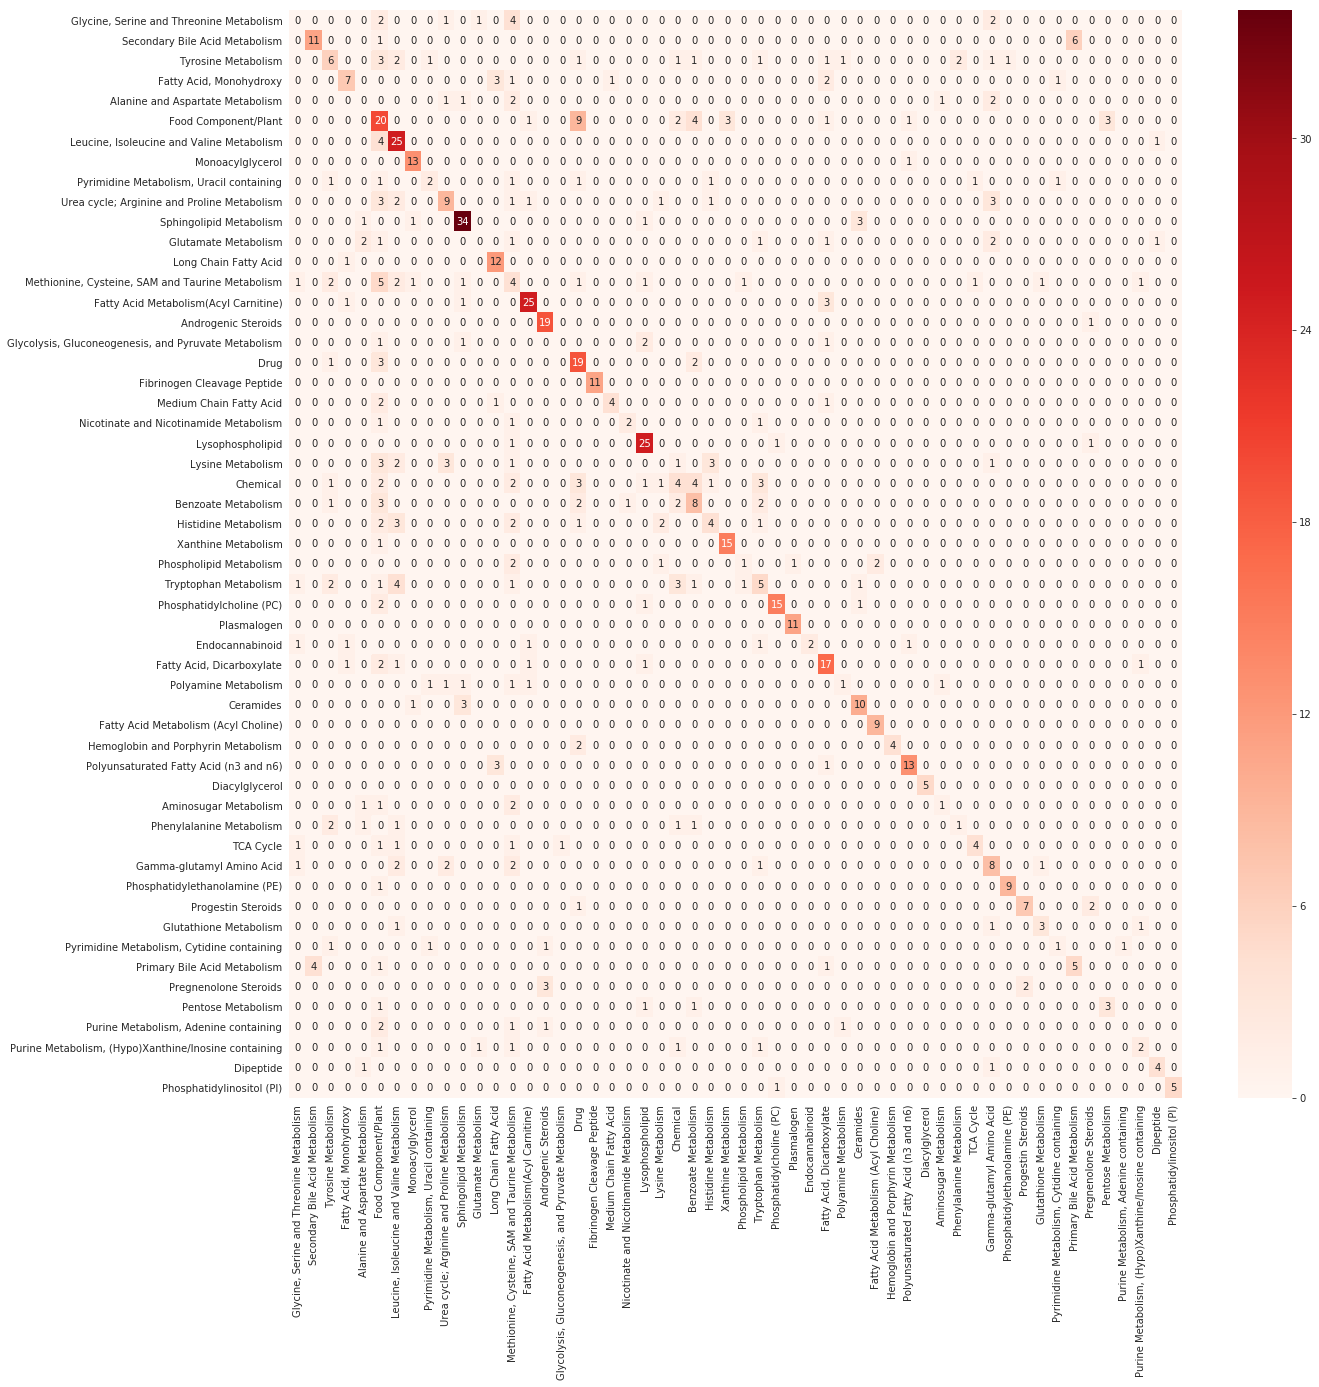

In [285]:
con_mat = _multi_class_confusion_matrix(true_y, loo_predictions['all_features+levels'], y_labels, y_labels_dic)
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(con_mat, ax=ax, cmap='Reds', annot=con_mat, fmt='d')

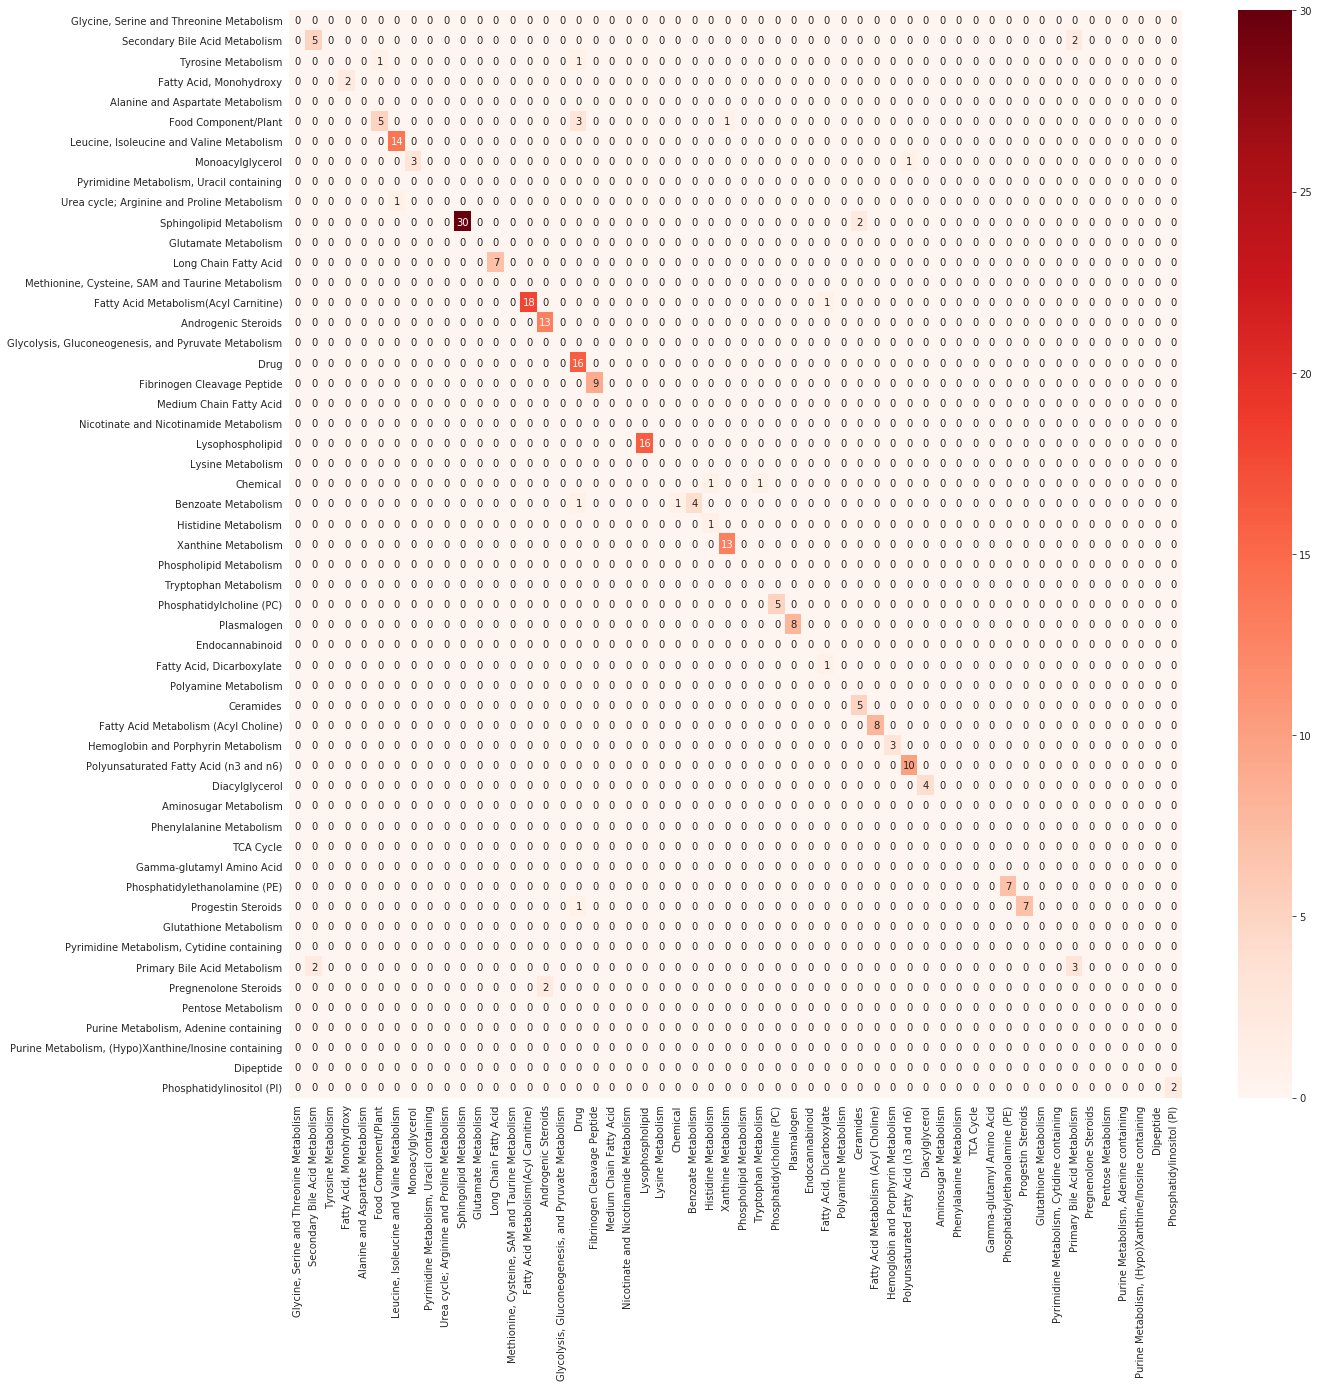

In [292]:
con_mat = _multi_class_confusion_matrix(true_y.loc[loo_predictions['all_features+levels'][loo_predictions['all_features+levels'].max(1) > 0.8].index], 
                                        loo_predictions['all_features+levels'][loo_predictions['all_features+levels'].max(1) > 0.8], y_labels, y_labels_dic)
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(con_mat, ax=ax, cmap='Reds', annot=con_mat, fmt='d')

### Supp figure

[0.5630810092961488, 0.6865869853917663, 0.749003984063745, 0.7795484727755644, 0.8034528552456839, 0.8286852589641434]


Text(-0.15, 0.95, 'C')

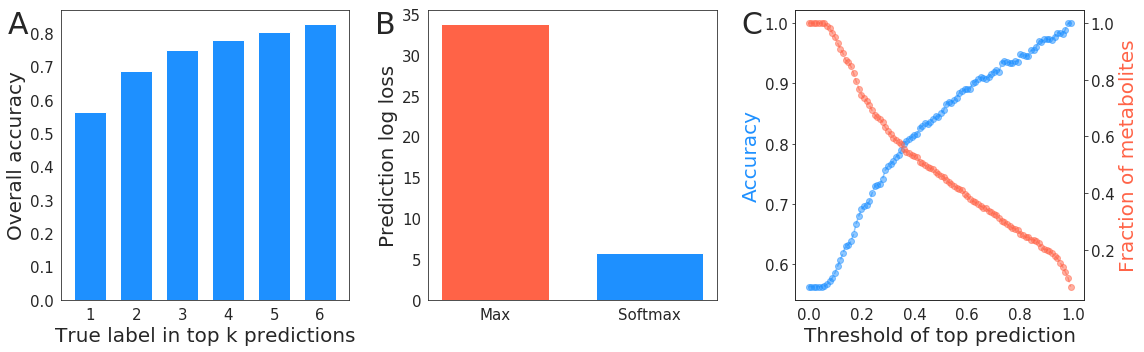

In [336]:
loo = 'all_features+shap+levels'
acc_vs_max_df = accuracy_vs_max(true_y, y_labels_dic, loo_predictions[loo])
acc_vs_max_df['Accuracy'] = acc_vs_max_df['Hit'] / acc_vs_max_df['n']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
tick_fontsize = 15
label_fontsize = 20

ax = axes[0]
y_temp = true_y.replace(y_labels_dic).copy()
first_hit = _highest_proba_hit(loo_predictions[loo], y_temp)
k_acc = [first_hit.sum()/y_temp.shape[0]]
b = loo_predictions[loo].copy()
for i in range(5):
    b[(b.T == b.T.max()).T] = 0
    hit = _highest_proba_hit(b, y_temp)
    k_acc.append(hit.sum()/y_temp.shape[0] + k_acc[-1])
print (k_acc)
ax.bar(range(len(k_acc)), k_acc, width=0.7, color='dodgerblue')
ax.set_xticks(range(len(k_acc)))
ax.set_xticklabels(range(1, len(k_acc)+1), fontsize=tick_fontsize)
ax.set_xlabel('True label in top k predictions', fontsize=label_fontsize)
ax.set_ylabel('Overall accuracy', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)

ax = axes[1]
prob = log_loss(pd.get_dummies(true_y.replace(y_labels_dic)), loo_predictions[loo].loc[true_y.index])
dum = log_loss(pd.get_dummies(true_y.replace(y_labels_dic)), loo_predictions[loo].loc[true_y.index].apply(lambda x: x == x.max(), axis=1).astype(int))

ax.bar([0, 1], [dum, prob], width=0.7, color=['tomato', 'dodgerblue'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['Max', 'Softmax'], fontsize=tick_fontsize)
ax.set_ylabel('Prediction log loss', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)

ax = axes[2]
ax.plot(acc_vs_max_df.index, acc_vs_max_df['Accuracy'], 'o--', color='dodgerblue', alpha=0.5)
ax2 = ax.twinx()
ax2.plot(acc_vs_max_df.index, acc_vs_max_df['n'] / true_y.shape[0], 'o--', color='tomato', alpha=0.5)
ax.tick_params(labelsize=tick_fontsize)
ax2.tick_params(labelsize=tick_fontsize)
ax.set_ylabel('Accuracy', fontsize=label_fontsize, color='dodgerblue')
ax2.set_ylabel('Fraction of metabolites', fontsize=label_fontsize, color='tomato')
ax.set_xlabel('Threshold of top prediction', fontsize=label_fontsize)


fig.tight_layout()

plt.text(-0.15, 0.95, 'A', ha='center', va='center', transform=axes[0].transAxes, fontsize=30)
plt.text(-0.15, 0.95, 'B', ha='center', va='center', transform=axes[1].transAxes, fontsize=30)
plt.text(-0.15, 0.95, 'C', ha='center', va='center', transform=axes[2].transAxes, fontsize=30)

plt.savefig('Supplementary_sub_pathway5_small.png', dpi=200, bbox_inches='tight')
plt.savefig('Supplementary_sub_pathway5.png', dpi=1200, bbox_inches='tight')

In [286]:
con_mat_super_pathway = con_mat.rename(index=sub_pathway_2_super_pathway_dict).index.copy()
top1_sub_pathway = con_mat.copy()
top1_sub_pathway['Support'] = con_mat.sum(1)
top1_sub_pathway.index = con_mat_super_pathway
top1_sub_pathway.columns = con_mat_super_pathway.tolist() + ['Support']
# top1_sub_pathway = top1_sub_pathway.loc[top1_sub_pathway['Support']>10, (top1_sub_pathway['Support'] >10).values.tolist() + [True]]
for sp in top1_sub_pathway.index.unique():
    print (sp, top1_sub_pathway.loc[sp, sp].sum().sum(), top1_sub_pathway.loc[sp, 'Support'].sum())

Amino acids 120 190
Lipids 320 341
Xeno. 106 126
Nucleotides 8 26
Carbohydrates 4 16
Peptides 24 34
Cofactors and Vitamins 6 11
Energy 4 9


In [287]:
con_mat_super_pathway = con_mat.rename(index=sub_pathway_2_super_pathway_dict).index.copy()
top1_sub_pathway = con_mat.copy()
top1_sub_pathway['Support'] = con_mat.sum(1)
top1_sub_pathway.index = con_mat_super_pathway
top1_sub_pathway.columns = con_mat_super_pathway.tolist() + ['Support']
top1_sub_pathway = top1_sub_pathway.loc[top1_sub_pathway['Support']>10, (top1_sub_pathway['Support'] >10).values.tolist() + [True]]
for sp in top1_sub_pathway.index.unique():
    print (sp, top1_sub_pathway.loc[sp, sp].sum().sum(), top1_sub_pathway.loc[sp, 'Support'].sum())

Lipids 259 274
Amino acids 89 144
Xeno. 106 126
Peptides 19 28


# 30 unknowns table

In [589]:
unknow_table = metabs1[metabs1.CHEMICAL_ID.isin(identified_molecules)][['CHEMICAL_ID', 'BIOCHEMICAL', 'COMMENT']].set_index('CHEMICAL_ID').copy()
unknow_table.rename(columns={'BIOCHEMICAL': 'Identified molecule', 'COMMENT': 'Candidate structure'}, inplace=True)
unknow_table.loc[unknow_table['Identified molecule'].str.contains('X - '), 'Identified molecule'] = None
unknow_table['True SUPER_PATHWAY'] = None
unknow_table['True SUB_PATHWAY'] = None
unknow_table['Predicted SUPER_PATHWAY'] = unknow_predictions_super_pathway['all_features+levels'].loc[identified_molecules].idxmax(1).copy()
unknow_table['Predicted SUB_PATHWAY'] = unknow_predictions_sub_pathway['all_features+levels'].loc[identified_molecules].idxmax(1).copy()
unknow_table.sort_values('Identified molecule', inplace=True)
unknow_table.to_csv('unknow_table.csv')

In [691]:
unknow_predictions_sub_pathway['all_features+levels'].loc['X - 24809']

Ceramides                                           0.084755
Chemical                                            0.022650
Androgenic Steroids                                 0.006982
Leucine, Isoleucine and Valine Metabolism           0.020728
Lysophospholipid                                    0.115543
Food Component/Plant                                0.124507
Plasmalogen                                         0.013490
Tryptophan Metabolism                               0.078489
Sphingolipid Metabolism                             0.120759
Benzoate Metabolism                                 0.014510
Methionine, Cysteine, SAM and Taurine Metabolism    0.019982
Tyrosine Metabolism                                 0.064428
Polyunsaturated Fatty Acid (n3 and n6)              0.005099
Secondary Bile Acid Metabolism                      0.015429
Drug                                                0.007020
Fatty Acid, Dicarboxylate                           0.018312
Gamma-glutamyl Amino Aci

In [683]:
metabs1[metabs1.SUB_PATHWAY.fillna('').str.contains('Ben')]

,Group HMDB_ID,Sample HMDB_ID,BIOCHEMICAL,CAS,CHEMICAL_ID,CHEMSPIDER,KEGG,MASS,PATHWAY_SORTORDER,PLATFORM,PUBCHEM,RI,SUB_PATHWAY,SUPER_PATHWAY,COMMENT
COMP_ID,,,,,,,,,,,,,,,
18281,HMDB00840,NaN,2-hydroxyhippurate (salicylurate),487-54-7,1869,9835.0,C07588,194.04588,3497.0,LC/MS Neg,10253.0,2184.0,Benzoate Metabolism,Xenobiotics,2-hydroxyhippurate (salicylurate)
35635,HMDB00375,NaN,3-(3-hydroxyphenyl)propionate,621-54-5,100001624,89.0,C11457,165.05571,3574.0,LC/MS Neg,91.0,1980.0,Benzoate Metabolism,Xenobiotics,3-(3-hydroxyphenyl)propionate
45415,NaN,NaN,3-(3-hydroxyphenyl)propionate sulfate,86321-32-6,100005391,162993.0,NaN,245.01253,3571.0,LC/MS Neg,187488.0,1294.0,Benzoate Metabolism,Xenobiotics,3-(3-hydroxyphenyl)propionate sulfate
39600,HMDB06116,NaN,3-hydroxyhippurate,1637-75-8,100002122,396603.0,NaN,194.04588,3498.0,LC/MS Neg,450268.0,1687.0,Benzoate Metabolism,Xenobiotics,3-hydroxyhippurate
48763,NaN,NaN,3-methoxycatechol sulfate (1),NaN,100006375,NaN,NaN,218.99688,3551.0,LC/MS Neg,NaN,2163.0,Benzoate Metabolism,Xenobiotics,3-methoxycatechol sulfate (1)
48752,NaN,NaN,3-methoxycatechol sulfate (2),NaN,100006376,NaN,NaN,218.99688,3552.0,LC/MS Neg,NaN,2200.0,Benzoate Metabolism,Xenobiotics,3-methoxycatechol sulfate (2)
46165,NaN,NaN,3-methyl catechol sulfate (1),NaN,100004112,NaN,NaN,203.00196,3526.0,LC/MS Neg,NaN,2790.0,Benzoate Metabolism,Xenobiotics,3-methyl catechol sulfate (1)
46164,NaN,NaN,3-methyl catechol sulfate (2),NaN,100004110,NaN,NaN,203.00196,3527.0,LC/MS Neg,NaN,2860.0,Benzoate Metabolism,Xenobiotics,3-methyl catechol sulfate (2)
15749,HMDB00764,NaN,3-phenylpropionate (hydrocinnamate),501-52-0,100000010,10181339.0,C05629,149.06080,3576.0,LC/MS Neg,107.0,2860.0,Benzoate Metabolism,Xenobiotics,3-phenylpropionate (hydrocinnamate)


In [686]:
metabs1[metabs1.BIOCHEMICAL.fillna('').str.contains('bromo')]

,Group HMDB_ID,Sample HMDB_ID,BIOCHEMICAL,CAS,CHEMICAL_ID,CHEMSPIDER,KEGG,MASS,PATHWAY_SORTORDER,PLATFORM,PUBCHEM,RI,SUB_PATHWAY,SUPER_PATHWAY,COMMENT
COMP_ID,,,,,,,,,,,,,,,
53242,NaN,NaN,5-bromotryptophan,NaN,100009338,87339.0,NaN,280.99311,243.0,LC/MS Neg,96735.0,3525.0,Tryptophan Metabolism,Amino Acid,5-bromotryptophan
46368,NaN,NaN,"3-bromo-5-chloro-2,6-dihydroxybenzoic acid*",NaN,X - 18914,NaN,NaN,266.88894,NaN,LC/MS Neg,NaN,4503.0,NaN,NaN,X - 18914


In [614]:
metabs1[metabs1.CHEMICAL_ID == '1111']

,Group HMDB_ID,Sample HMDB_ID,BIOCHEMICAL,CAS,CHEMICAL_ID,CHEMSPIDER,KEGG,MASS,PATHWAY_SORTORDER,PLATFORM,PUBCHEM,RI,SUB_PATHWAY,SUPER_PATHWAY,COMMENT
COMP_ID,,,,,,,,,,,,,,,
1567,HMDB00291,NaN,vanillylmandelate (VMA),55-10-7,1111,1207.0,C05584,197.04555,151.0,LC/MS Neg,1245.0,941.0,Tyrosine Metabolism,Amino Acid,vanillylmandelate (VMA)


# retired unknowns

In [390]:
retired_molecules = updated_metabs1[(updated_metabs1.SUPER_PATHWAY.notnull()) & (updated_metabs1.index.str.contains('X - '))].index
list_of_identified_unknowns = list(set(retired_molecules).union(set(identified_molecules)))

In [391]:
len(list_of_identified_unknowns)

92

In [392]:
sub_pathway_2_super_pathway_dict

{'Acetylated Peptides': 'Peptides',
 'Alanine and Aspartate Metabolism': 'Amino acids',
 'Aminosugar Metabolism': 'Carbohydrates',
 'Androgenic Steroids': 'Lipids',
 'Ascorbate and Aldarate Metabolism': 'Cofactors and Vitamins',
 'Bacterial/Fungal': 'Xeno.',
 'Benzoate Metabolism': 'Xeno.',
 'Carnitine Metabolism': 'Lipids',
 'Ceramides': 'Lipids',
 'Chemical': 'Xeno.',
 'Corticosteroids': 'Lipids',
 'Creatine Metabolism': 'Amino acids',
 'Diacylglycerol': 'Lipids',
 'Dipeptide': 'Peptides',
 'Dipeptide Derivative': 'Peptides',
 'Disaccharides and Oligosaccharides': 'Carbohydrates',
 'Drug': 'Xeno.',
 'Drug - Analgesics, Anesthetics': 'Xeno.',
 'Drug - Topical Agents': 'Xeno.',
 'Eicosanoid': 'Lipids',
 'Endocannabinoid': 'Lipids',
 'Estrogenic Steroids': 'Lipids',
 'Fatty Acid Metabolism (Acyl Choline)': 'Lipids',
 'Fatty Acid Metabolism (Acyl Glutamine)': 'Lipids',
 'Fatty Acid Metabolism (also BCAA Metabolism)': 'Lipids',
 'Fatty Acid Metabolism(Acyl Carnitine)': 'Lipids',
 'Fatty A

In [484]:
get_nlargest_cols(unknow_predictions_sub_pathway['all_features+shap+levels'].loc[list_of_identified_unknowns], col_name='Predicted SUB_PATHWAY', val_name='Prediction probability')\
.loc['X - 24809']

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


Predicted SUB_PATHWAY #1            Lysophospholipid
Prediction probability #1                   0.169914
Predicted SUB_PATHWAY #2        Food Component/Plant
Prediction probability #2                  0.0970622
Predicted SUB_PATHWAY #3     Sphingolipid Metabolism
Prediction probability #3                   0.088831
Name: X - 24809, dtype: object

In [515]:
unknowns_table = updated_metabs1.loc[list_of_identified_unknowns, ['BIOCHEMICAL', 'COMMENT', 'SUB_PATHWAY', 'SUPER_PATHWAY']]
unknowns_table.rename(columns={'BIOCHEMICAL': 'Identified molecule', 'COMMENT': 'Candidate structure', 
                               'SUPER_PATHWAY': 'True SUPER_PATHWAY',  'SUB_PATHWAY': 'True SUB_PATHWAY'}, inplace=True)
unknowns_table.loc[unknowns_table['Identified molecule'].str.contains('X - '), 'Identified molecule'] = None
# unknowns_table['Predicted SUPER_PATHWAY'] = unknow_predictions_super_pathway['all_features'].loc[list_of_identified_unknowns].idxmax(1).copy()
n = 3
unknowns_table = pd.concat((unknowns_table, 
                            get_nlargest_cols(unknow_predictions_sub_pathway['all_features+shap+levels']\
                                              .loc[list_of_identified_unknowns], col_name='Predicted SUB_PATHWAY', val_name='Prediction probability', n=n)\
                            .loc[list_of_identified_unknowns]), axis=1)
for i in range(1, n+1):
    unknowns_table['Predicted SUPER_PATHWAY #%0.1d'%i] = [sub_pathway_2_super_pathway_dict[k] if not pd.isnull(k) else None for k in unknowns_table['Predicted SUB_PATHWAY #%0.1d'%i]]
# unknowns_table['Predicted SUB_PATHWAY'] = unknow_predictions_sub_pathway['all_features+shap+levels'].loc[list_of_identified_unknowns].idxmax(1).copy()
# unknowns_table['Predicted SUPER_PATHWAY'] = [sub_pathway_2_super_pathway_dict[k] for k in unknowns_table['Predicted SUB_PATHWAY']]
# unknowns_table['Prediction probability'] = unknow_predictions_sub_pathway['all_features+shap+levels'].loc[list_of_identified_unknowns].max(1).copy()
unknowns_table['Microbiome r2'] = mb_full_results.loc[unknowns_table.index, 'Coefficient_of_determination']
unknowns_table.sort_values('Microbiome r2', inplace=True, ascending=False)
# unknowns_table[unknowns_table['Microbiome r2'] > 0.05].to_csv()
unknowns_table.head(20)
unknowns_table.to_csv('unknowns_table.csv')

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [509]:
unknowns_table
unknow_predictions_sub_pathway['all_features+shap+levels'].loc[list_of_identified_unknowns].idxmax(1).copy()
# len(list_of_identified_unknowns)
sub_pathway_2_super_pathway_dict[np.nan]
unknowns_table['Predicted SUB_PATHWAY #%0.1d'%1].loc['X - 21729']
[sub_pathway_2_super_pathway_dict[k] for k in unknowns_table['Predicted SUB_PATHWAY #%0.1d'%1]]

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


KeyError: nan

In [415]:
sub_pathway_labels.shape

(28,)

In [446]:
unknowns_table[(unknowns_table['True SUB_PATHWAY'].notnull()) 
               & (unknowns_table['Predicted SUB_PATHWAY'].notnull()) 
               & (unknowns_table['True SUB_PATHWAY'] != 'Partially Characterized Molecules')
               & (unknowns_table['True SUB_PATHWAY'].isin(sub_pathway_labels))
               & (unknowns_table['Prediction probability'] > 0.0033)].shape
# (unknowns_table['True SUB_PATHWAY'] == unknowns_table['Predicted SUB_PATHWAY']).sum()
# ((unknowns_table['True SUPER_PATHWAY'].replace({'Xenobiotics': 'Xeno.', 'Lipid': 'Lipids', 'Amino acid': 'Amino acids'}) == unknowns_table['Predicted SUPER_PATHWAY']) \
#  & (unknowns_table['True SUB_PATHWAY'].isin(sub_pathway_labels)) & (unknowns_table['Prediction probability'] > 0.0033)).sum()
# ((unknowns_table['True SUB_PATHWAY'] == unknowns_table['Predicted SUB_PATHWAY']) \
#  & (unknowns_table['True SUB_PATHWAY'].isin(sub_pathway_labels)) & (unknowns_table['Prediction probability'] > 0.0033)).sum()

(36, 8)

# Difference in distributions of predictions

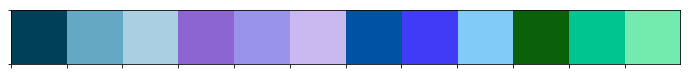

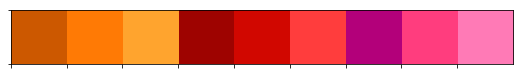

In [53]:
costume_colors_features = ['#004159', '#65A8C4', '#AACEE2', '#8C65D3', '#9A93EC', '#CAB9F1', '#0052A5', '#413BF7', '#81CBF8', '#0B610B', '#00C590', '#73EBAE']
costume_colors_metabs = ['#CC5800', '#FF7A05', '#FFA42E', '#9E0300', '#D10700', '#FF3D3D', '#B3007A', '#FF3D7E', '#FF7AB6']
sns.palplot(costume_colors_features)
# plt.savefig(os.path.join(paper_dir, 'colors_features.png'), dpi=50, bbox_inches='tight')
sns.palplot(costume_colors_metabs)
# plt.savefig(os.path.join(paper_dir, 'colors_metabs.png'), dpi=50, bbox_inches='tight')

super_pathway_color = {'Cofactors and Vitamins':costume_colors_metabs[0],'Peptides':costume_colors_metabs[1], 'Lipids':costume_colors_metabs[2],
                      'Amino acids':costume_colors_metabs[3], 'Energy':costume_colors_metabs[4], 'Xenobiotics':costume_colors_metabs[5],
                      'Carbohydrates':costume_colors_metabs[6], 'Nucleotides':costume_colors_metabs[7],'Unknowns':costume_colors_metabs[8]}

In [ ]:
# show a suplementary figure that shows the distribution of predictions for the unknows, and compare to the predicted and actual named molecules.

In [71]:
df_sub_pathway = pathway_predictions_dist(metabs1[metabs1.SUB_PATHWAY.isin(known_predictions_sub_pathway['all_features+levels'].columns)].SUB_PATHWAY.value_counts(), 
                                                                       known_predictions_sub_pathway['all_features+levels'],
                                                                       unknow_predictions_sub_pathway['all_features+levels'].loc[unknow_predictions_sub_pathway['all_features+levels'].index.str.startswith('X')])

/usr/wisdom/python3/lib/python3.5/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [72]:
df_sub_pathway

,SUB_PATHWAY,Predictions (named),Predictions (unnamed)
Androgenic Steroids,0.032310,0.034965,0.042683
Benzoate Metabolism,0.038772,0.031469,0.024390
Ceramides,0.022617,0.020979,NaN
Chemical,0.040388,0.024476,0.054878
Drug,0.080775,0.061189,0.088415
Fatty Acid Metabolism(Acyl Carnitine),0.053312,0.050699,0.039634
"Fatty Acid, Dicarboxylate",0.042003,0.040210,0.079268
"Fatty Acid, Monohydroxy",0.024233,0.019231,0.015244
Fibrinogen Cleavage Peptide,0.019386,0.017483,0.003049
Food Component/Plant,0.079160,0.096154,0.268293


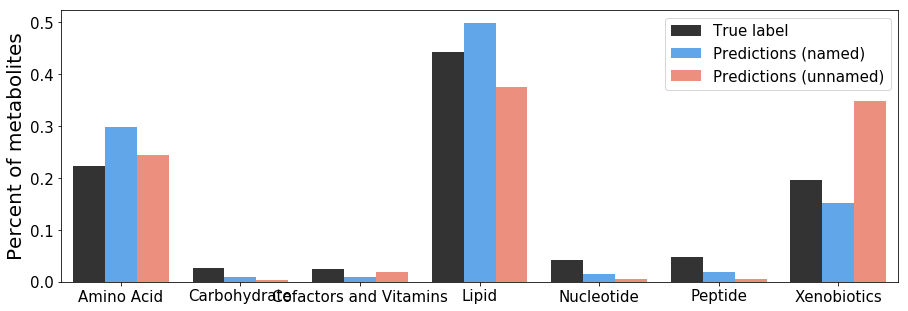

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.barplot(data=df.reset_index().melt(id_vars=['index'], value_vars=df.columns).replace('SUPER_PATHWAY', 'True label'), x='index', y='value', hue='variable', ax=ax, palette=['black', 'dodgerblue', 'tomato'], alpha=0.8)
ax.tick_params(labelsize=15)
ax.set_xlabel('')
ax.set_ylabel('Percent of metabolites', fontsize=20)

ax.legend(title='', fontsize=15)
# df

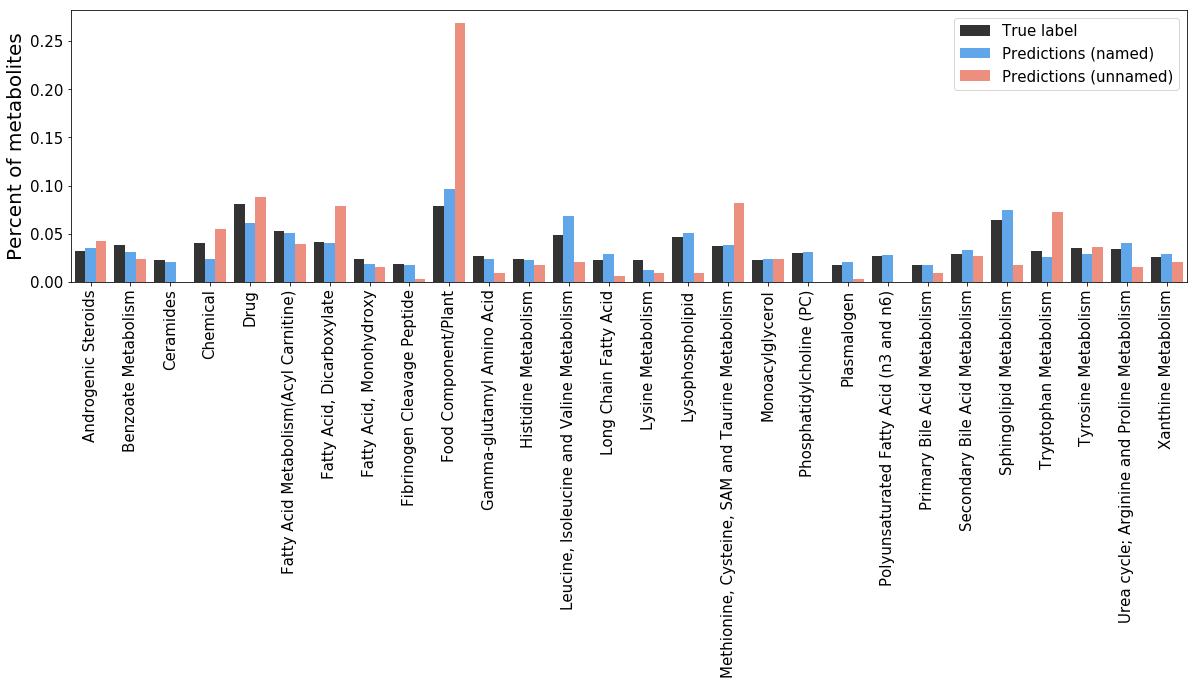

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

sns.barplot(data=df_sub_pathway.reset_index().melt(id_vars=['index'], value_vars=df_sub_pathway.columns).replace('SUB_PATHWAY', 'True label'), x='index', y='value', hue='variable', 
            ax=ax, palette=['black', 'dodgerblue', 'tomato'], alpha=0.8)
ax.tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Percent of metabolites', fontsize=20)

ax.legend(title='', fontsize=15)
# df